In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import researchpy as rp

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import statsmodels.api as sm
import scikit_posthocs as sp
import statsmodels.formula.api as smf
from matplotlib import image as mpimg
import matplotlib 

from PIL import Image
from IPython.display import display

cutoff = 290

with open('config.json') as infile:
    config = json.load(infile)
    
repo = config['laptop']

def cohen_d(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    print('Effect size d: {}'.format((u1 - u2) / s))

# Dataset

In [2]:
df = pd.read_csv('FINAL_DATA.csv', header=[0], index_col=[0])
print(df.head())

     gap   pass    method  run  traj_length  collisions  goal     run0  \
0  right  right  baseline    0  2205.090339           0     0  134.052   
1  right  right  baseline    1  1766.261838           0     0  133.866   
2  right   left  baseline    2  1349.305974           1     1   63.168   
3  right   left  baseline    3  1453.481414           1     1  120.878   
4  right   left  baseline    4  1431.427287           1     1  104.271   

     run1    run2  ...  swap_total_median  swap_free_min  swap_free_max  \
0  31.391  52.528  ...                100            100            100   
1  38.852  57.886  ...                100            100            100   
2  38.763  48.509  ...                100            100            100   
3  48.769  41.704  ...                100            100            100   
4  41.205  36.477  ...                100            100            100   

   swap_free_mean  swap_free_median  swap_used_min  swap_used_max  \
0             100               100

# Trajectories

In [3]:
df_traj = df[['method', 'gap', 'goal', 'collisions', 'traj_length']]
df_traj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   method       90 non-null     object 
 1   gap          90 non-null     object 
 2   goal         90 non-null     int64  
 3   collisions   90 non-null     int64  
 4   traj_length  90 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


## Method

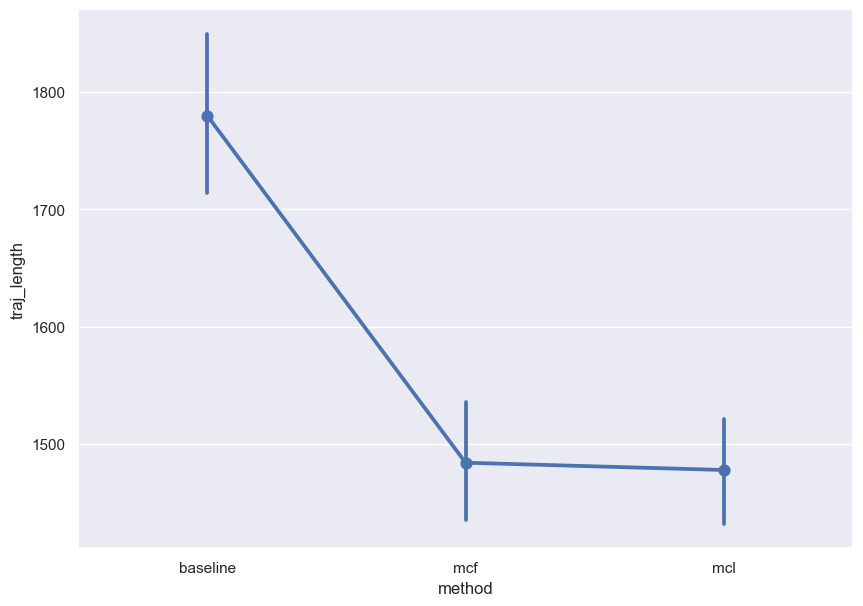

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=df_traj, x='method', y='traj_length')
plt.show()

In [5]:
print(df.groupby(by='method').traj_length.describe().T)

method     baseline          mcf          mcl
count     30.000000    30.000000    30.000000
mean    1779.933803  1484.032582  1477.811040
std      198.833141   139.032966   123.465544
min     1349.305974  1224.647792  1273.604573
25%     1771.124746  1479.806720  1463.403359
50%     1797.204860  1518.515362  1514.597969
75%     1851.431743  1546.585486  1542.712862
max     2205.090339  1960.616975  1843.349227


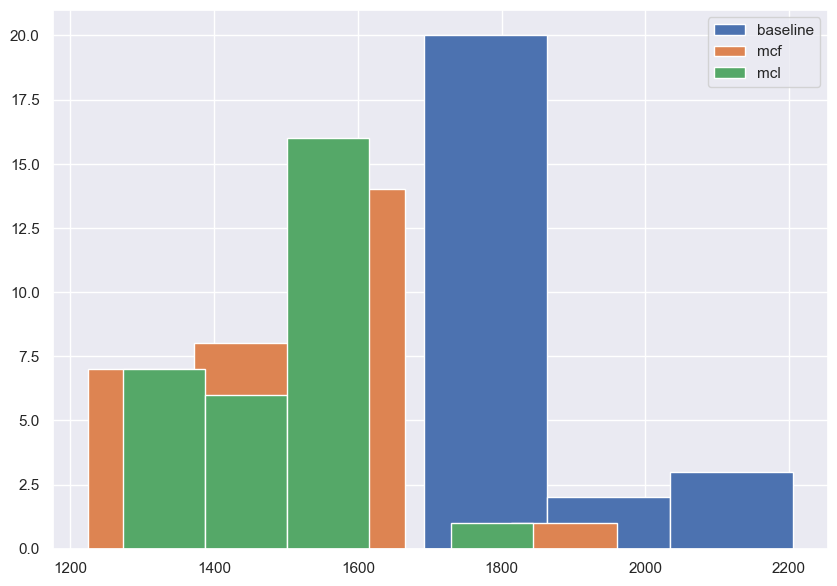

In [6]:
baseline = df_traj[df_traj.method == 'baseline']
mcf = df_traj[df_traj.method == 'mcf']
mcl = df_traj[df_traj.method == 'mcl']

plt.figure(figsize=(10, 7))
baseline.traj_length.hist(label='baseline', bins=5)
mcf.traj_length.hist(label='mcf', bins=5)
mcl.traj_length.hist(label='mcl', bins=5)
plt.legend()
plt.show()

## Normality assumption

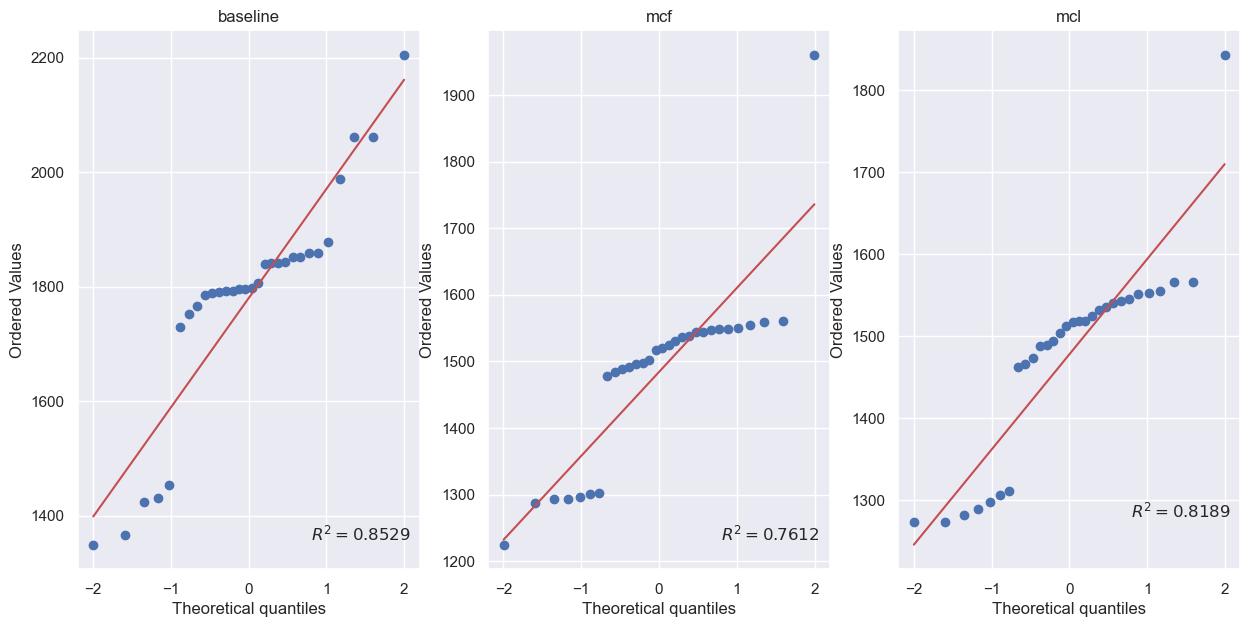

In [7]:
fig, ax = plt.subplots(1, 3, figsize= (15, 7))
stats.probplot(baseline.traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('baseline', fontsize=12)
stats.probplot(mcf.traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('mcf', fontsize=12)
stats.probplot(mcl.traj_length, plot=ax[2], rvalue=True)
ax[2].set_title('mcl', fontsize=12)
plt.show()

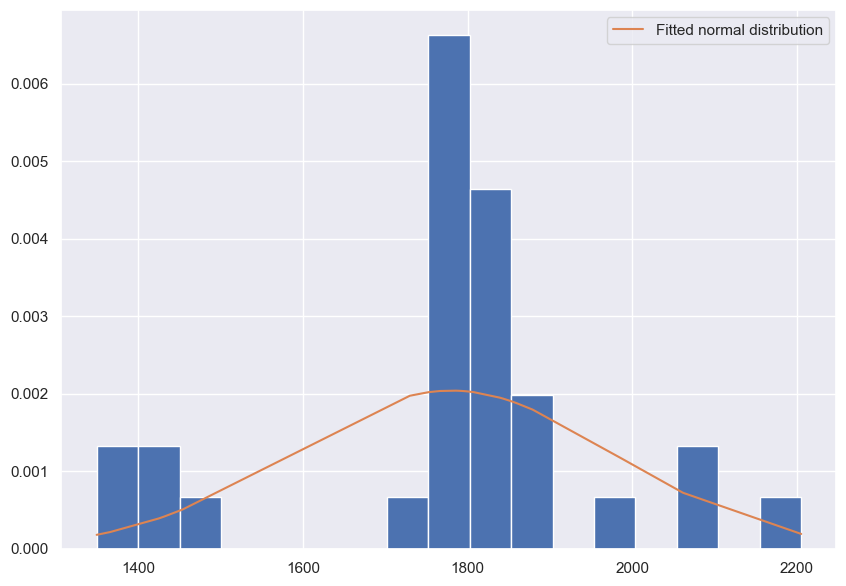

In [8]:
def normal_plot(variable):
    variable = variable.copy()
    variable.values.sort()
    mean, std = stats.norm.fit(variable, loc=0)
    pdf_norm = stats.norm.pdf(variable, mean, std)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(variable, bins='auto', density=True)
    ax.plot(variable, pdf_norm, label='Fitted normal distribution')
    ax.legend()
    
normal_plot(baseline.traj_length)

In [9]:
def normal_test_battery(sample):
    stat, p = stats.shapiro(sample)
    if p < 0.05:
        print('Shapiro-Wilk s={:.3f} p={:.3f}, data does not look normal (reject H0)'.format(stat, p))
    else:
        print('Shapiro-Wilk s={:.3f} p={:.3f}, data looks normal (accept H0)'.format(stat, p))

    try:
        stat, p = stats.normaltest(sample)
        if p < 0.05:
            print('D’Agostino K^2 s={:.3f} p={:.3f}, data does not look normal (reject H0)'.format(stat, p))
        else:
            print('D’Agostino K^2 s={:.3f} p={:.3f}, data looks normal (accept H0)'.format(stat, p))
    except ValueError:
        pass
    
    result = stats.anderson(sample)
    print('\nAnderson-Darling s={}'.format(result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('{:.3f}: {:.3f}, data looks normal (accept H0)'.format(sl, cv))
        else:
            print('{:.3f}: {:.3f}, data does not look normal (reject H0)'.format(sl, cv))
            
normal_test_battery(baseline.traj_length)

Shapiro-Wilk s=0.859 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=3.622 p=0.164, data looks normal (accept H0)

Anderson-Darling s=2.145643922801817
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


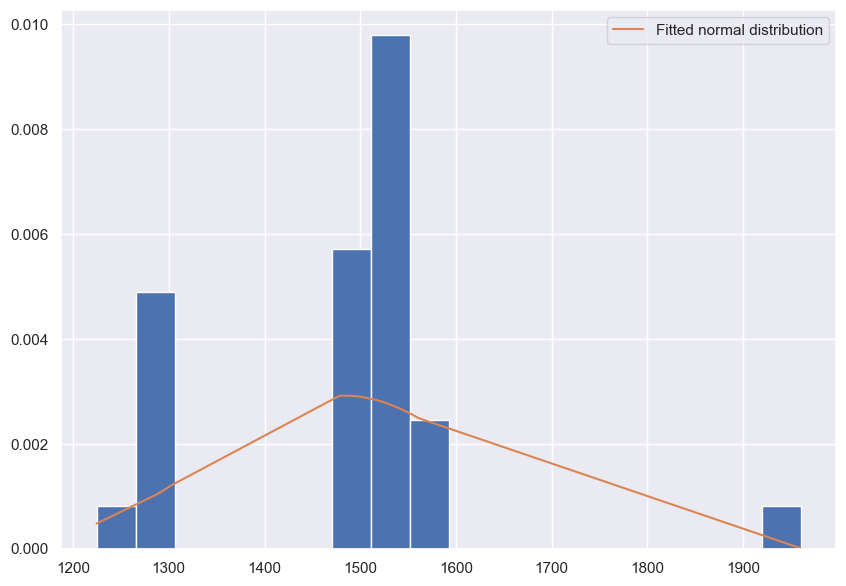

In [10]:
normal_plot(mcf.traj_length)

In [11]:
normal_test_battery(mcf.traj_length)

Shapiro-Wilk s=0.783 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=10.542 p=0.005, data does not look normal (reject H0)

Anderson-Darling s=2.6016998122341946
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


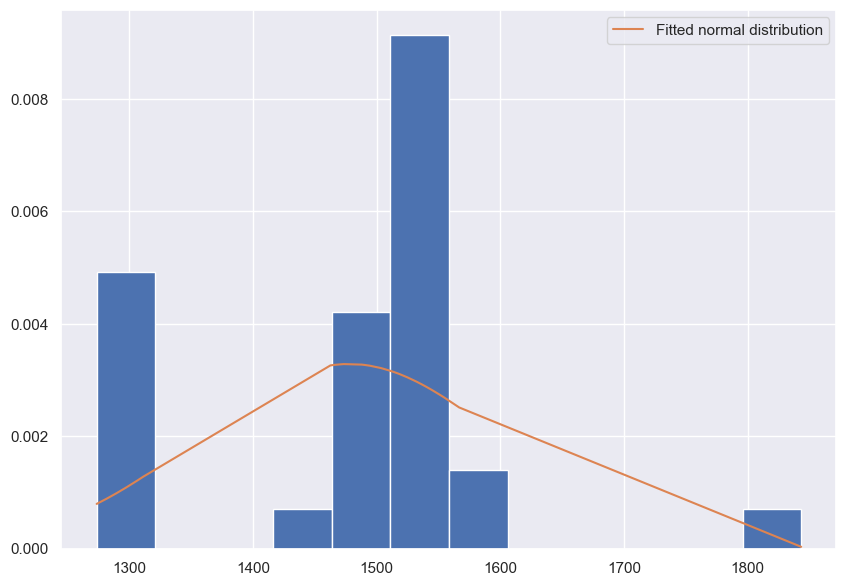

In [12]:
normal_plot(mcl.traj_length)

In [13]:
normal_test_battery(mcl.traj_length)

Shapiro-Wilk s=0.829 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=2.906 p=0.234, data looks normal (accept H0)

Anderson-Darling s=2.1712836654526413
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


## Variances

In [14]:
print(stats.levene(df_traj[df_traj.method == 'baseline'].traj_length,
                   df_traj[df_traj.method == 'mcf'].traj_length,
                   df_traj[df_traj.method == 'mcl'].traj_length))

LeveneResult(statistic=1.092953756524277, pvalue=0.339782673825452)


In [15]:
print(df_traj.groupby(by='method').traj_length.describe().T)

method     baseline          mcf          mcl
count     30.000000    30.000000    30.000000
mean    1779.933803  1484.032582  1477.811040
std      198.833141   139.032966   123.465544
min     1349.305974  1224.647792  1273.604573
25%     1771.124746  1479.806720  1463.403359
50%     1797.204860  1518.515362  1514.597969
75%     1851.431743  1546.585486  1542.712862
max     2205.090339  1960.616975  1843.349227


### Examine outliers

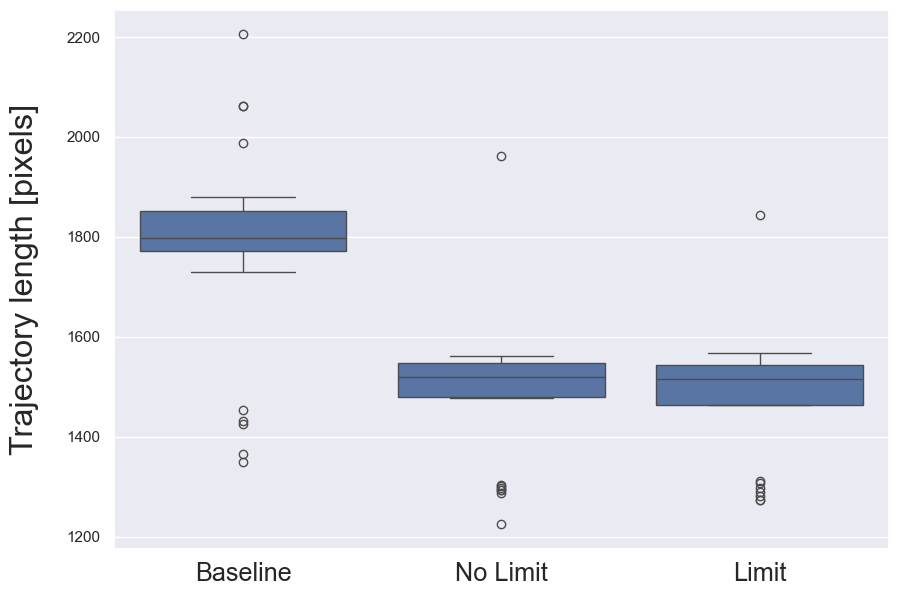

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=df_traj, x='method', y='traj_length')
ax.set_ylabel('Trajectory length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Baseline', 'No Limit', 'Limit'], fontsize=14*1.3)
plt.savefig('methodgoal.eps', transparent=False)
plt.show()

In [123]:
df_corr = pd.DataFrame()

for n, g in df_traj.groupby(by='method'):
    df_corr[n] = g.traj_length.values
    
print(rp.corr_pair(df_corr))

                r value p-value   N
baseline & mcf   0.0141  0.9409  30
baseline & mcl  -0.0598  0.7535  30
mcf & mcl        0.3736  0.0420  30


In [124]:
print(stats.kruskal(df_traj[df_traj.method == 'baseline'].traj_length,
                    df_traj[df_traj.method == 'mcf'].traj_length,
                    df_traj[df_traj.method == 'mcl'].traj_length))

KruskalResult(statistic=29.408449328449308, pvalue=4.111841520738287e-07)


In [125]:
print(sp.posthoc_dunn(df_traj, val_col='traj_length', group_col='method', p_adjust='bonferroni'))

          baseline       mcf       mcl
baseline  1.000000  0.000014  0.000005
mcf       0.000014  1.000000  1.000000
mcl       0.000005  1.000000  1.000000


In [126]:
print(stats.f_oneway(df_traj[df_traj.method == 'baseline'].traj_length,
                     df_traj[df_traj.method == 'mcf'].traj_length,
                     df_traj[df_traj.method == 'mcl'].traj_length))

F_onewayResult(statistic=36.20522850557766, pvalue=3.627491393580361e-12)


In [127]:
print(sp.posthoc_ttest(df_traj, val_col='traj_length', group_col='method', p_adjust='bonferroni'))

              baseline           mcf           mcl
baseline  1.000000e+00  3.024591e-08  6.699322e-09
mcf       3.024591e-08  1.000000e+00  1.000000e+00
mcl       6.699322e-09  1.000000e+00  1.000000e+00


# Between gap

## Baseline

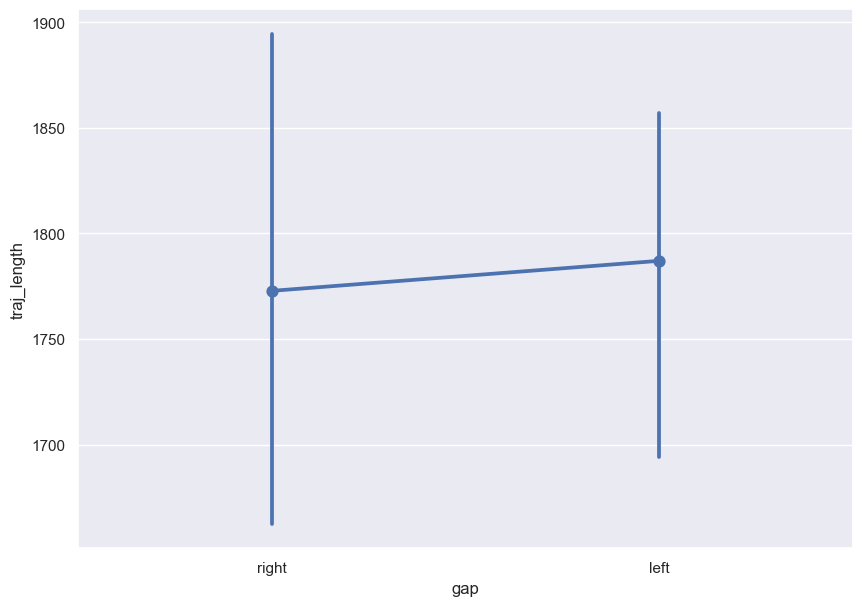

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=baseline, x='gap', y='traj_length')
plt.show()

In [23]:
print(baseline.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1787.049659  1772.817947
std     174.873869   226.282485
min    1365.624677  1349.305974
25%    1779.938074  1775.987654
50%    1841.972603  1791.858020
75%    1855.046206  1797.204860
max    2061.814568  2205.090339


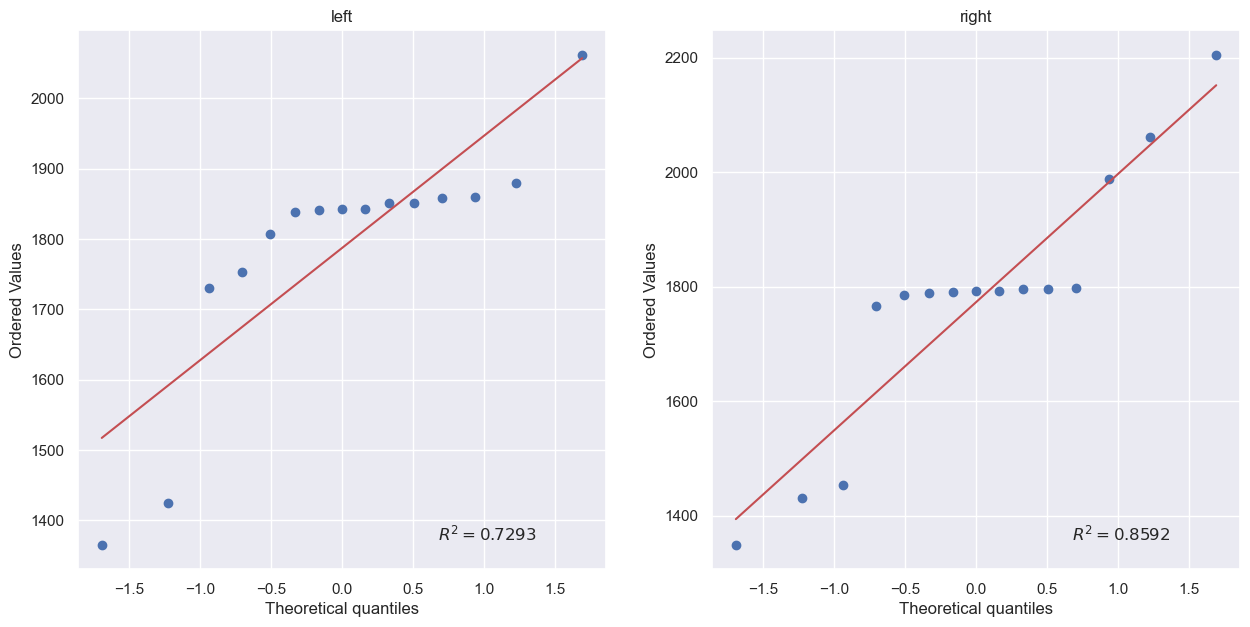

In [24]:
fig, ax = plt.subplots(1, 2, figsize= (15, 7))
stats.probplot(baseline[baseline.gap == 'left'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('left', fontsize=12)
stats.probplot(baseline[baseline.gap == 'right'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('right', fontsize=12)
plt.show()

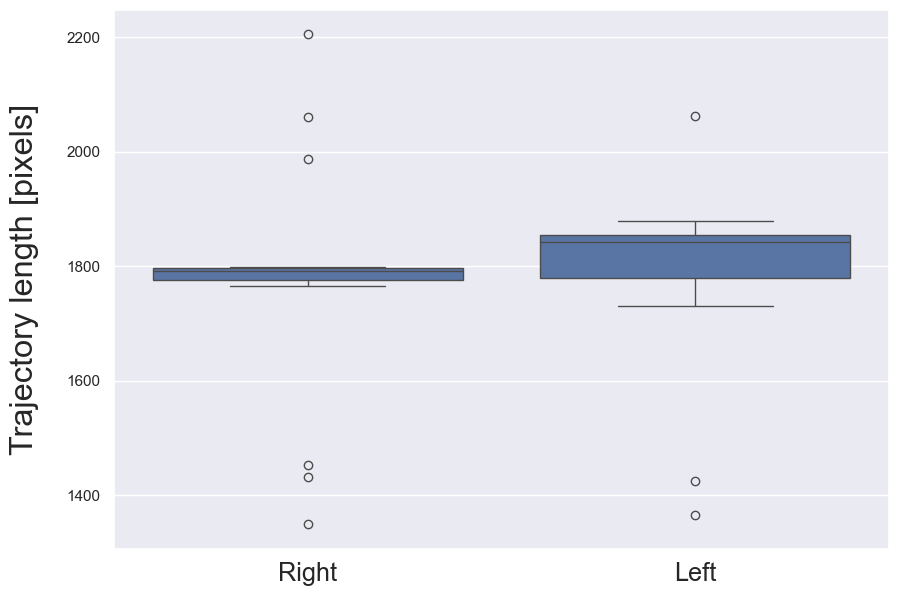

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=baseline, x='gap', y='traj_length')
ax.set_ylabel('Trajectory length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Right', 'Left'], fontsize=14*1.3)
plt.savefig('baselinescenario1.eps', transparent=False)
plt.show()

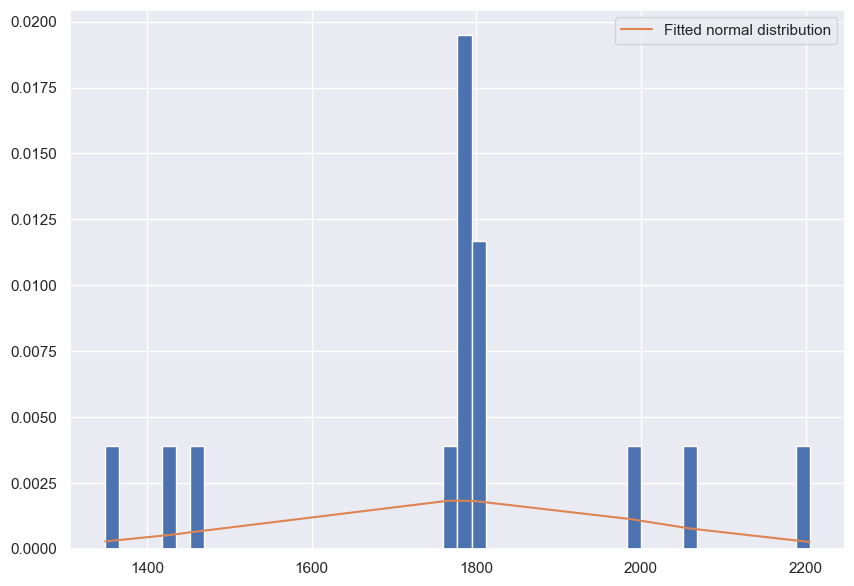

In [26]:
normal_plot(baseline[baseline.gap == 'right'].traj_length)

In [27]:
normal_test_battery(baseline[baseline.gap == 'right'].traj_length)

Shapiro-Wilk s=0.871 p=0.034, data does not look normal (reject H0)
D’Agostino K^2 s=0.553 p=0.758, data looks normal (accept H0)

Anderson-Darling s=1.1381801754242353
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


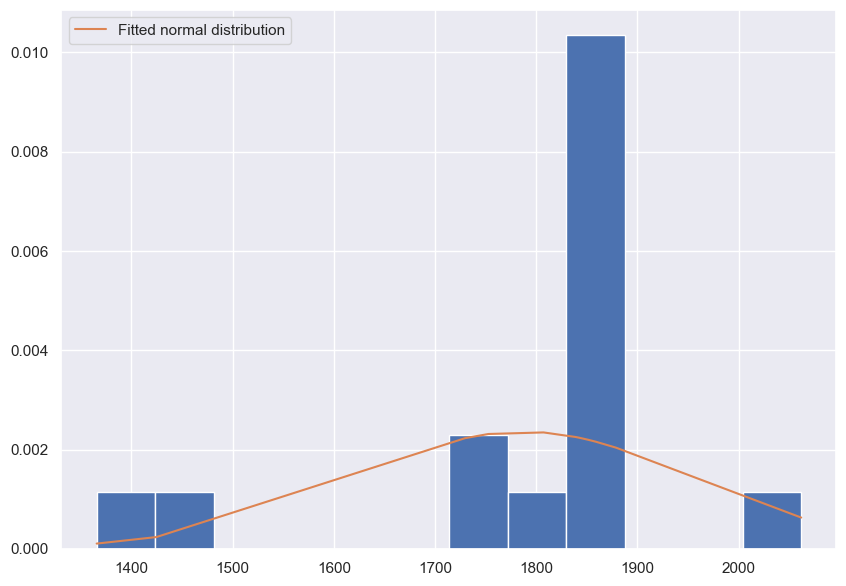

In [28]:
normal_plot(baseline[baseline.gap == 'left'].traj_length)

In [29]:
normal_test_battery(baseline[baseline.gap == 'left'].traj_length)

Shapiro-Wilk s=0.754 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=9.844 p=0.007, data does not look normal (reject H0)

Anderson-Darling s=1.827459940755645
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


In [30]:
print(stats.levene(baseline[baseline.gap == 'left'].traj_length,
                   baseline[baseline.gap == 'right'].traj_length))

LeveneResult(statistic=0.4759859173802008, pvalue=0.4959251467796405)


In [31]:
print(baseline.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1787.049659  1772.817947
std     174.873869   226.282485
min    1365.624677  1349.305974
25%    1779.938074  1775.987654
50%    1841.972603  1791.858020
75%    1855.046206  1797.204860
max    2061.814568  2205.090339


In [32]:
print(stats.mannwhitneyu(baseline[baseline.gap== 'left'].traj_length, 
                         baseline[baseline.gap == 'right'].traj_length))

MannwhitneyuResult(statistic=142.0, pvalue=0.22902896662469463)


In [33]:
baseline['rank'] = baseline.traj_length.rank(method='min').values
baseline_left = baseline[baseline.gap == 'left']
baseline_right = baseline[baseline.gap == 'right']

def mannwhitney_stats(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    T1 = sample1.sum()
    print('Sum of ranks sample 1: {}'.format(T1))
    print('Mean rank sample 1: {}'.format(T1/n1))
    U1 = n1 * n2 + (n1 * (n1 + 1) / 2) - T1
    print('U sample 1: {}'.format(U1))
    print()
    T2 = sample2.sum()
    print('Sum of ranks sample 2: {}'.format(T2))
    print('Mean rank sample 2: {}'.format(T2/n2))
    U2 = n1 * n2 + (n2 * (n2 + 1) / 2) - T2
    print('U sample 2: {}'.format(U2))
    print()
    U = min([U1, U2])
    print('Test stat U: {}'.format(U))
    mU = n1 * n2 / 2
    print('Expected value of U: {}'.format(mU))
    sigU = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 2)
    print('Standard error of U: {}'.format(sigU))
    z = (U - mU) / sigU
    print('z-value: {}'.format(z))
    r = abs(z) / np.sqrt(n1)
    print('Effect size r={}'.format(r))
    
mannwhitney_stats(baseline_left['rank'], baseline_right['rank'])

Sum of ranks sample 1: 262.0
Mean rank sample 1: 17.466666666666665
U sample 1: 83.0

Sum of ranks sample 2: 203.0
Mean rank sample 2: 13.533333333333333
U sample 2: 142.0

Test stat U: 83.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -0.49953383286741593
Effect size r=0.12897908103751074


Permutation test pvalue=0.06200937990620094


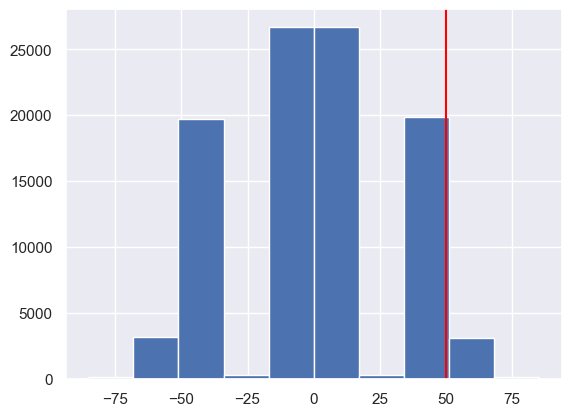

In [34]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((baseline[baseline.gap == 'left'].traj_length.values,
                                 baseline[baseline.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(baseline[baseline.gap == 'left'].traj_length.values, 
                      baseline[baseline.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=0.4253257467425326


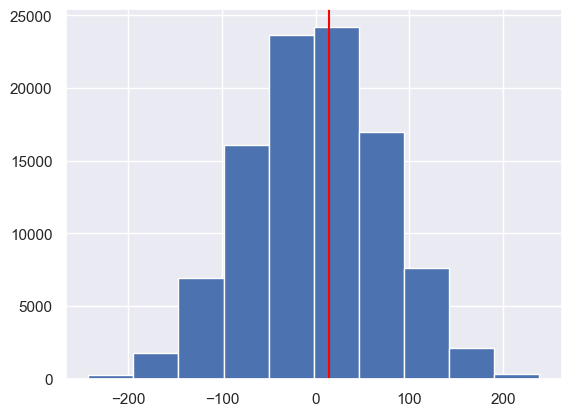

In [35]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((baseline[baseline.gap == 'left'].traj_length.values,
                                 baseline[baseline.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(baseline[baseline.gap == 'left'].traj_length.values, 
                      baseline[baseline.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

## Mcf

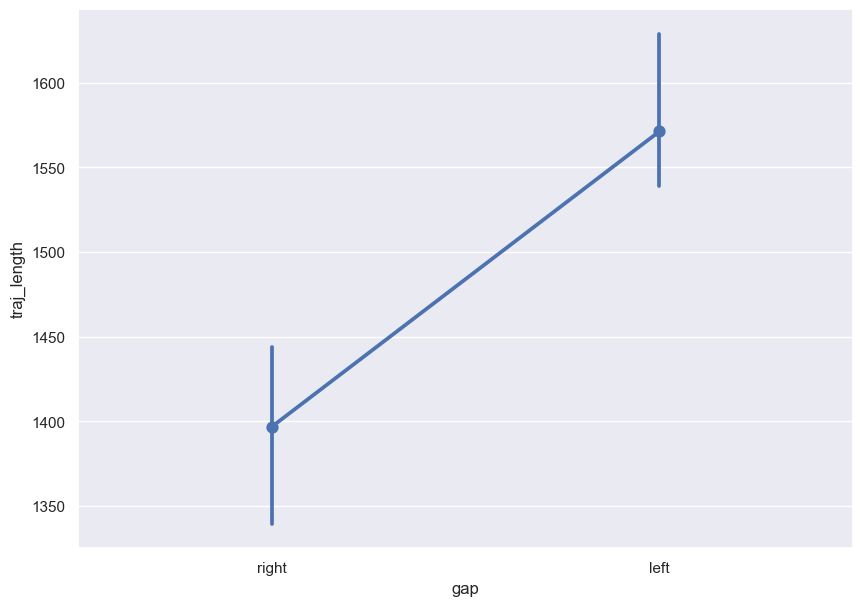

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=mcf, x='gap', y='traj_length')
plt.show()

In [37]:
print(mcf.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1571.174266  1396.890899
std     108.362379   109.665380
min    1520.633722  1224.647792
25%    1536.907316  1295.228616
50%    1547.319629  1478.172882
75%    1552.160203  1493.906661
max    1960.616975  1516.397001


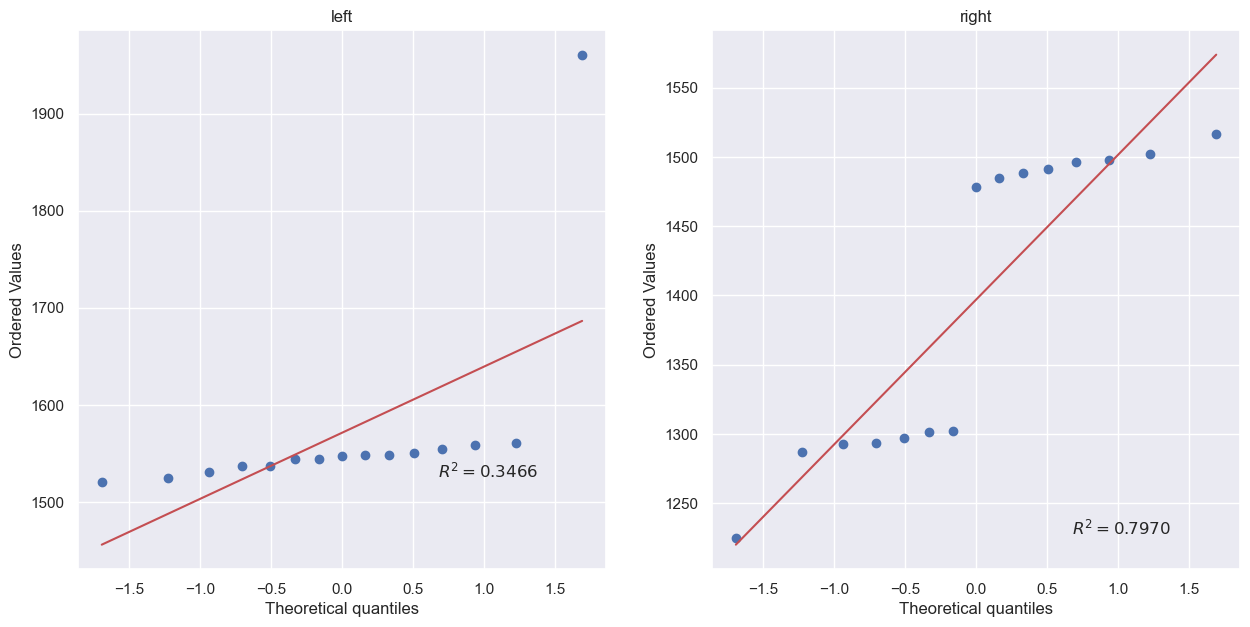

In [38]:
fig, ax = plt.subplots(1, 2, figsize= (15, 7))
stats.probplot(mcf[mcf.gap == 'left'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('left', fontsize=12)
stats.probplot(mcf[mcf.gap == 'right'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('right', fontsize=12)
plt.show()

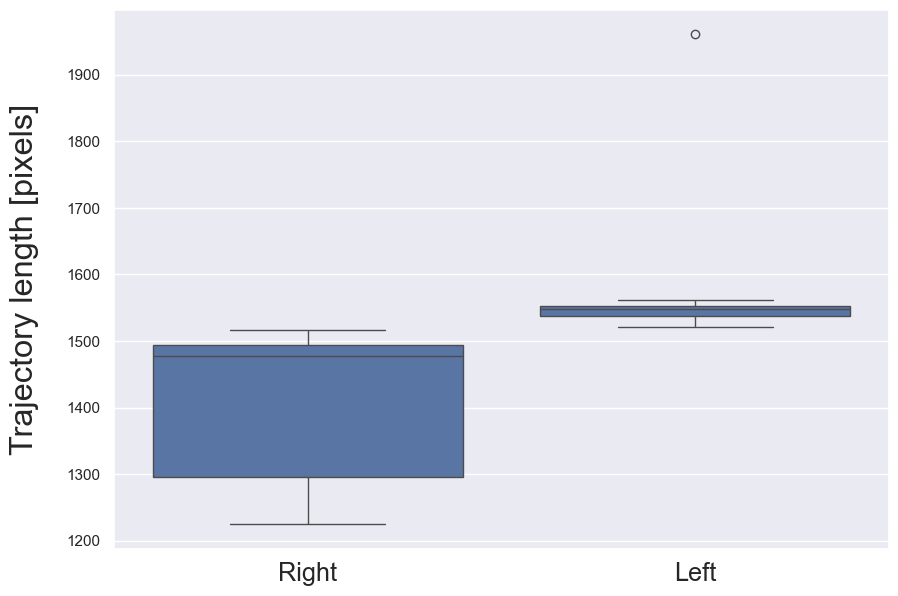

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=mcf, x='gap', y='traj_length')
ax.set_ylabel('Trajectory length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Right', 'Left'], fontsize=14*1.3)
plt.savefig('senariolimit.eps', transparent=False)
plt.show()

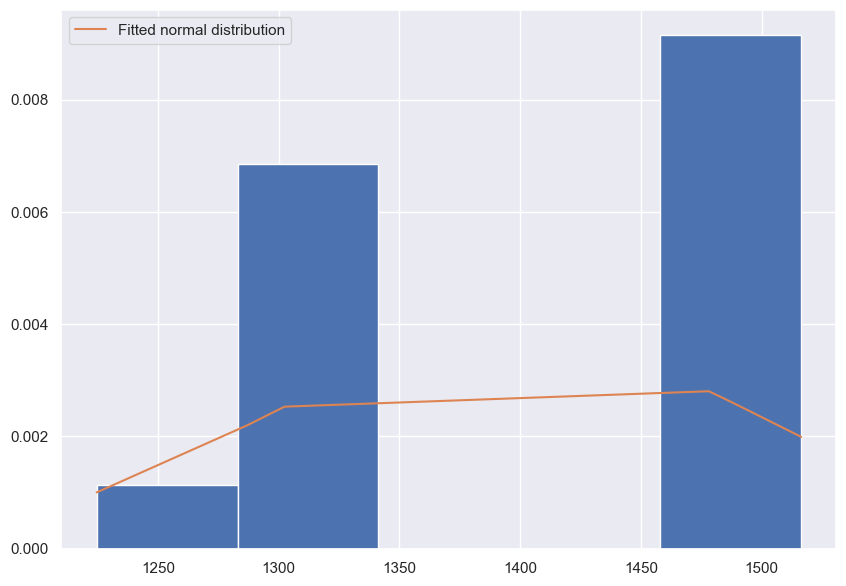

In [40]:
normal_plot(mcf[mcf.gap == 'right'].traj_length)

In [41]:
normal_test_battery(mcf[mcf.gap == 'right'].traj_length)

Shapiro-Wilk s=0.775 p=0.002, data does not look normal (reject H0)
D’Agostino K^2 s=12.783 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=1.6514923692013852
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


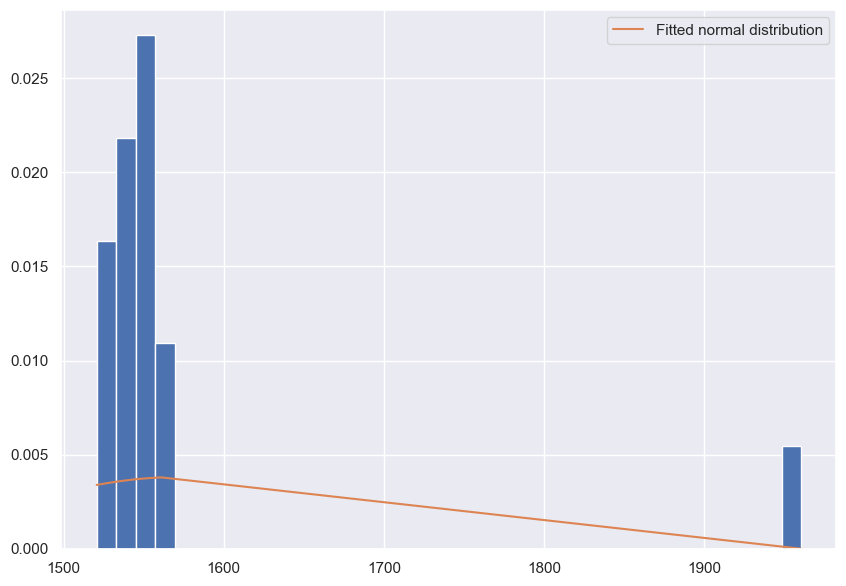

In [42]:
normal_plot(mcf[mcf.gap == 'left'].traj_length)

In [43]:
normal_test_battery(mcf[mcf.gap == 'left'].traj_length)

Shapiro-Wilk s=0.384 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=39.854 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=4.023674783705886
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


In [44]:
print(stats.levene(mcf[mcf.gap == 'left'].traj_length,
                   mcf[mcf.gap == 'right'].traj_length))

LeveneResult(statistic=2.968791228187075, pvalue=0.09591392639282152)


In [45]:
print(mcf.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1571.174266  1396.890899
std     108.362379   109.665380
min    1520.633722  1224.647792
25%    1536.907316  1295.228616
50%    1547.319629  1478.172882
75%    1552.160203  1493.906661
max    1960.616975  1516.397001


In [46]:
print(stats.mannwhitneyu(mcf[mcf.gap== 'left'].traj_length, 
                         mcf[mcf.gap == 'right'].traj_length))

MannwhitneyuResult(statistic=225.0, pvalue=3.3918213908250945e-06)


In [47]:
mcf['rank'] = mcf.traj_length.rank(method='min').values
mcf_left = mcf[mcf.gap == 'left']
mcf_right = mcf[mcf.gap == 'right']

mannwhitney_stats(mcf_left['rank'], mcf_right['rank'])

Sum of ranks sample 1: 345.0
Mean rank sample 1: 23.0
U sample 1: 0.0

Sum of ranks sample 2: 120.0
Mean rank sample 2: 8.0
U sample 2: 225.0

Test stat U: 0.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -1.9050019050028575
Effect size r=0.4918693768379647


Permutation test pvalue=2.999970000299997e-05


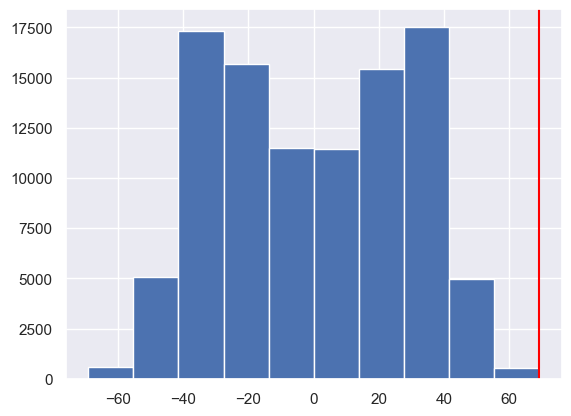

In [48]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((mcf[mcf.gap == 'left'].traj_length.values,
                                 mcf[mcf.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(mcf[mcf.gap == 'left'].traj_length.values, 
                      mcf[mcf.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=9.99990000099999e-06


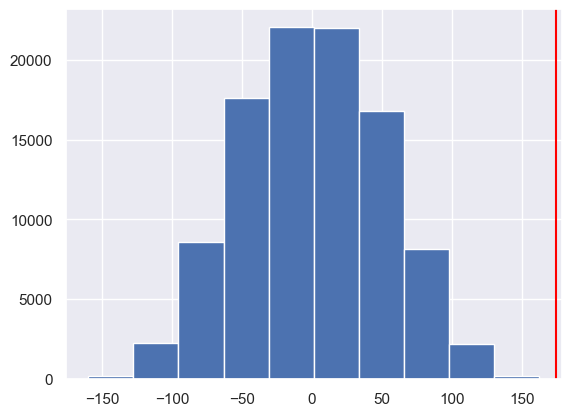

In [49]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((mcf[mcf.gap == 'left'].traj_length.values,
                                 mcf[mcf.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(mcf[mcf.gap == 'left'].traj_length.values, 
                      mcf[mcf.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

## Mcl

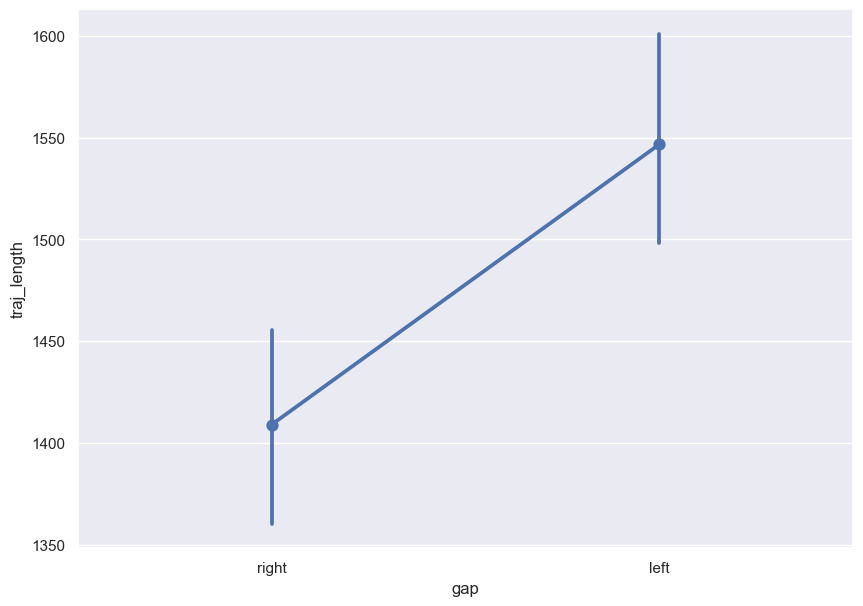

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=mcl, x='gap', y='traj_length')
plt.show()

In [51]:
print(mcl.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1546.636698  1408.985383
std     102.531425   104.465183
min    1311.173948  1273.604573
25%    1528.590282  1293.542881
50%    1543.326927  1465.679387
75%    1553.725951  1491.954306
max    1843.349227  1518.206366


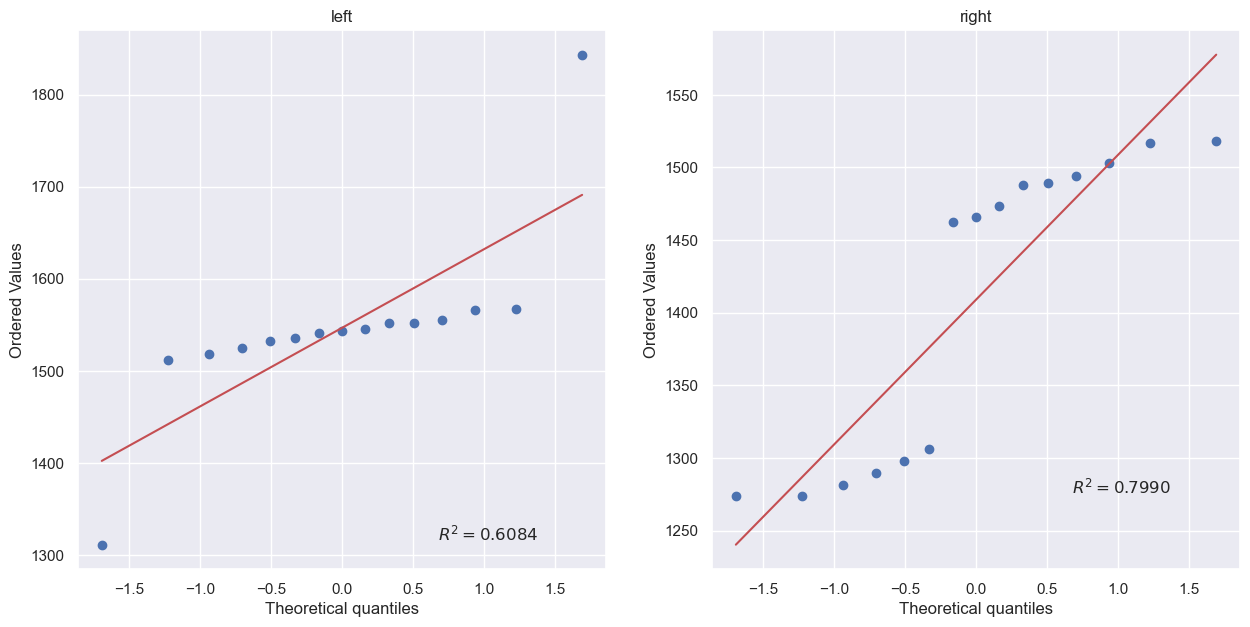

In [52]:
fig, ax = plt.subplots(1, 2, figsize= (15, 7))
stats.probplot(mcl[mcl.gap == 'left'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('left', fontsize=12)
stats.probplot(mcl[mcl.gap == 'right'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('right', fontsize=12)
plt.show()

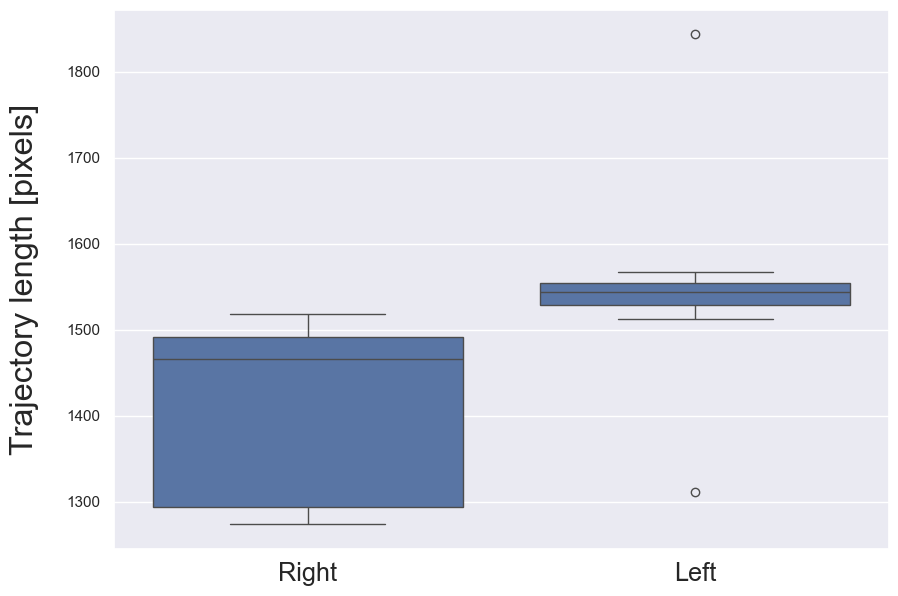

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=mcl, x='gap', y='traj_length')
ax.set_ylabel('Trajectory length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Right', 'Left'], fontsize=14*1.3)
plt.savefig('scenarionolimit.eps', transparent=False)
plt.show()

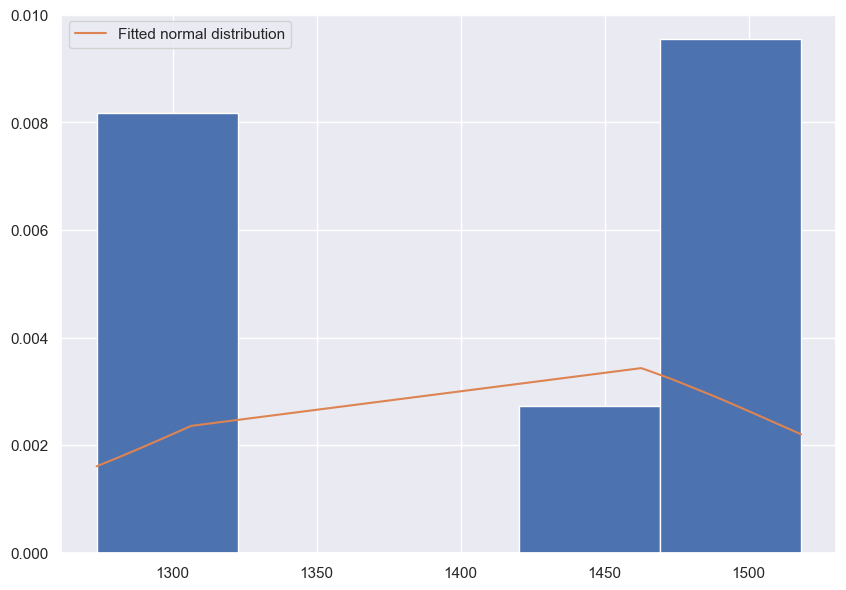

In [54]:
normal_plot(mcl[mcl.gap == 'right'].traj_length)

In [55]:
normal_test_battery(mcl[mcl.gap == 'right'].traj_length)

Shapiro-Wilk s=0.768 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=12.295 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=1.549060073631182
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


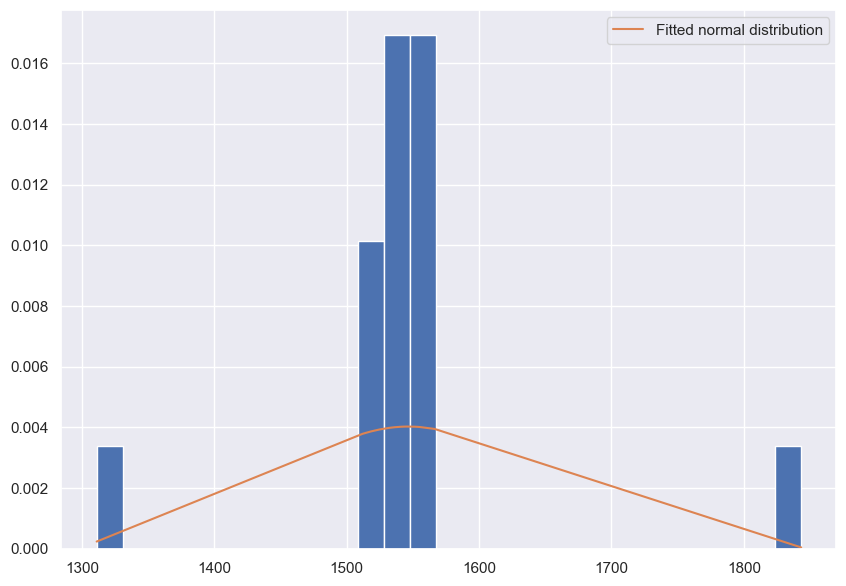

In [56]:
normal_plot(mcl[mcl.gap == 'left'].traj_length)

In [57]:
normal_test_battery(mcl[mcl.gap == 'left'].traj_length)

Shapiro-Wilk s=0.669 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=12.887 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=2.369932191988436
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


In [58]:
print(stats.levene(mcl[mcl.gap == 'left'].traj_length,
                   mcl[mcl.gap == 'right'].traj_length))

LeveneResult(statistic=1.6273653235180146, pvalue=0.21254994733386387)


In [59]:
print(mcl.groupby(by='gap').traj_length.describe().T)

gap           left        right
count    15.000000    15.000000
mean   1546.636698  1408.985383
std     102.531425   104.465183
min    1311.173948  1273.604573
25%    1528.590282  1293.542881
50%    1543.326927  1465.679387
75%    1553.725951  1491.954306
max    1843.349227  1518.206366


In [60]:
print(stats.mannwhitneyu(mcl[mcl.gap== 'left'].traj_length, 
                         mcl[mcl.gap == 'right'].traj_length))

MannwhitneyuResult(statistic=214.0, pvalue=2.7983495853192978e-05)


In [61]:
mcl['rank'] = mcl.traj_length.rank(method='min').values
mcl_left = mcl[mcl.gap == 'left']
mcl_right = mcl[mcl.gap == 'right']

mannwhitney_stats(mcl_left['rank'], mcl_right['rank'])

Sum of ranks sample 1: 334.0
Mean rank sample 1: 22.266666666666666
U sample 1: 11.0

Sum of ranks sample 2: 131.0
Mean rank sample 2: 8.733333333333333
U sample 2: 214.0

Test stat U: 11.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -1.7187350520692448
Effect size r=0.44377548221380814


Permutation test pvalue=0.00021999780002199978


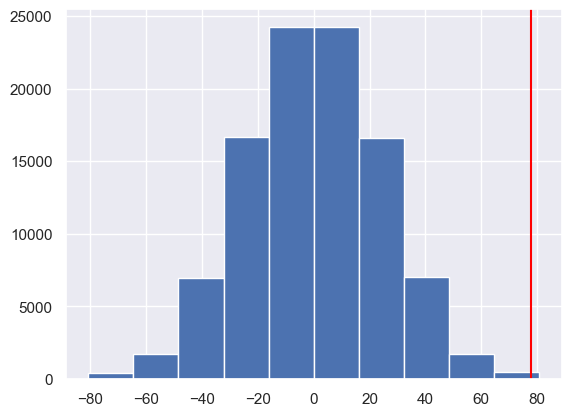

In [62]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((mcl[mcl.gap == 'left'].traj_length.values,
                                 mcl[mcl.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(mcl[mcl.gap == 'left'].traj_length.values, 
                      mcl[mcl.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=0.0005299947000529995


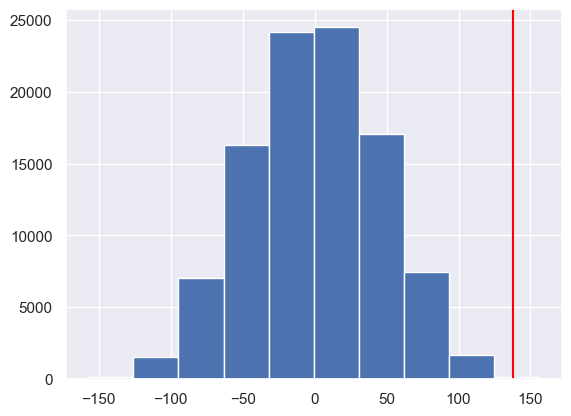

In [63]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((mcl[mcl.gap == 'left'].traj_length.values,
                                 mcl[mcl.gap == 'right'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(mcl[mcl.gap == 'left'].traj_length.values, 
                      mcl[mcl.gap == 'right'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

# Within gap

## Left

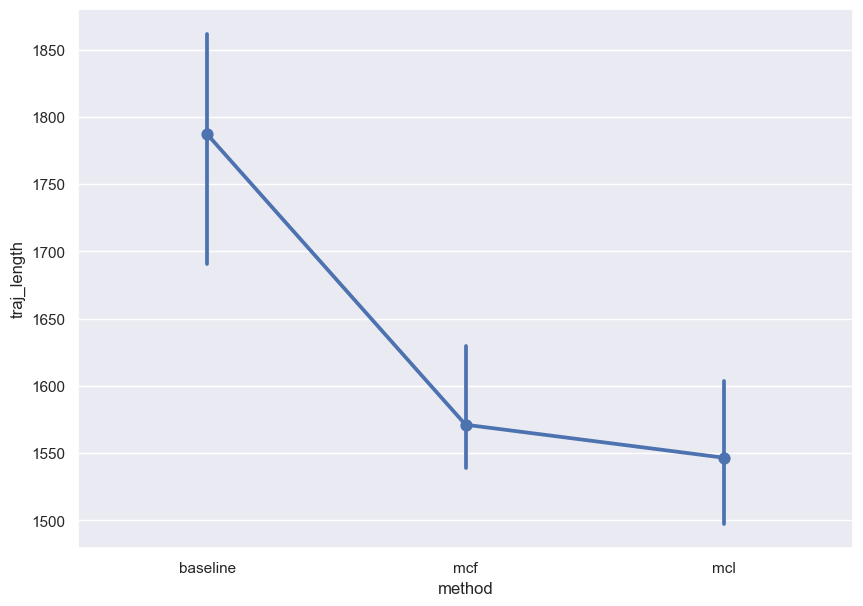

In [64]:
left = df_traj[df_traj.gap == 'left']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=left, x='method', y='traj_length')
plt.show()

In [65]:
print(left.groupby(by='method').traj_length.describe().T)

method     baseline          mcf          mcl
count     15.000000    15.000000    15.000000
mean    1787.049659  1571.174266  1546.636698
std      174.873869   108.362379   102.531425
min     1365.624677  1520.633722  1311.173948
25%     1779.938074  1536.907316  1528.590282
50%     1841.972603  1547.319629  1543.326927
75%     1855.046206  1552.160203  1553.725951
max     2061.814568  1960.616975  1843.349227


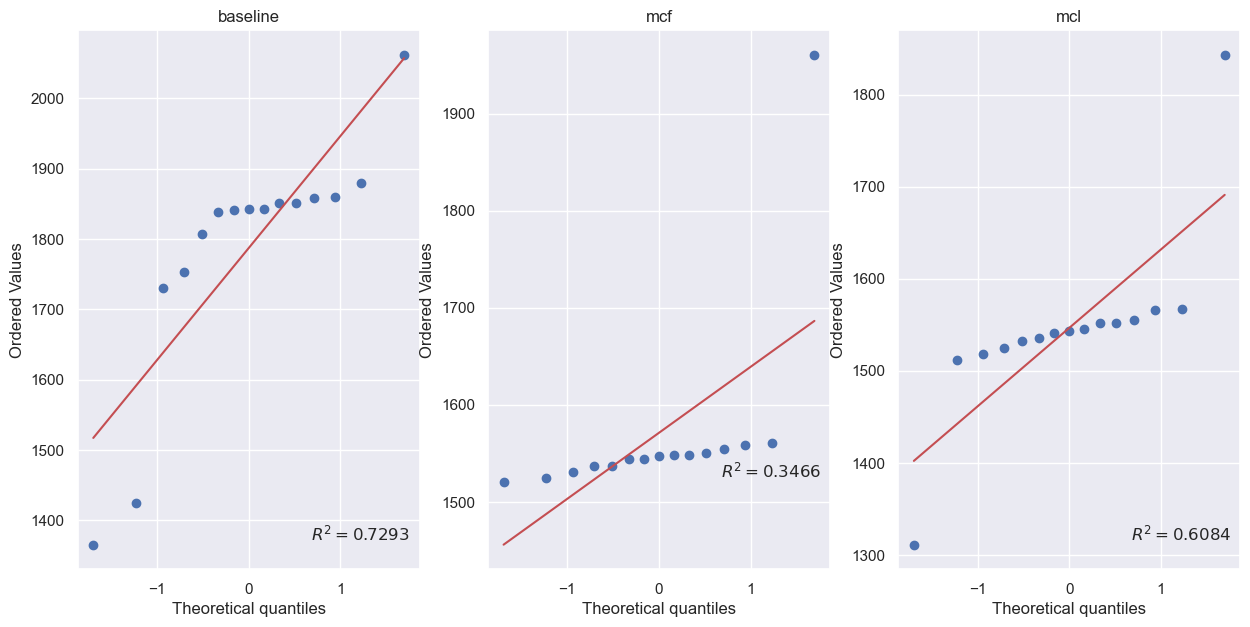

In [66]:
fig, ax = plt.subplots(1, 3, figsize= (15, 7))
stats.probplot(left[left.method == 'baseline'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('baseline', fontsize=12)
stats.probplot(left[left.method == 'mcf'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('mcf', fontsize=12)
stats.probplot(left[left.method == 'mcl'].traj_length, plot=ax[2], rvalue=True)
ax[2].set_title('mcl', fontsize=12)
plt.show()

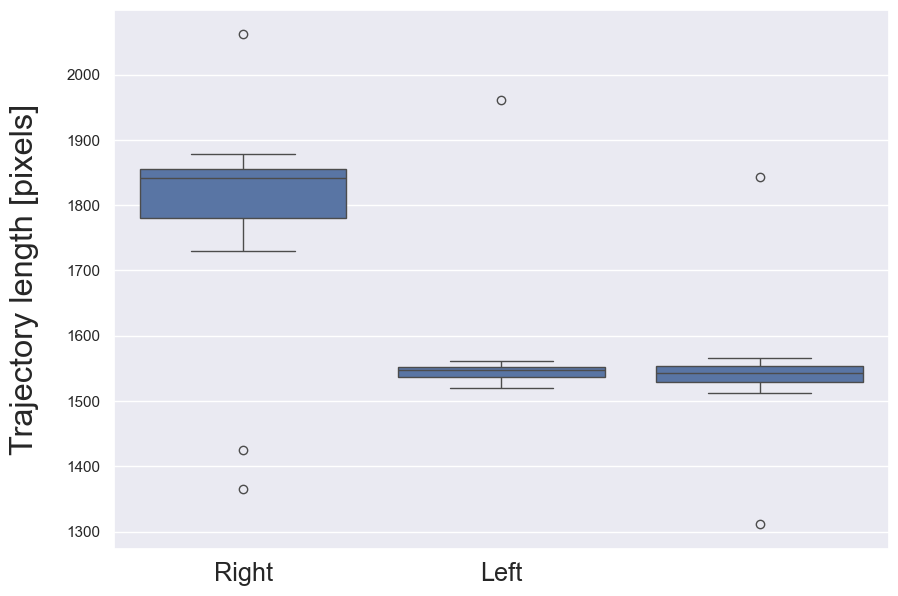

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=left, x='method', y='traj_length')
ax.set_ylabel('Trajectory length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Right', 'Left'], fontsize=14*1.3)
plt.savefig('scenariolimit.png', transparent=False)
plt.show()

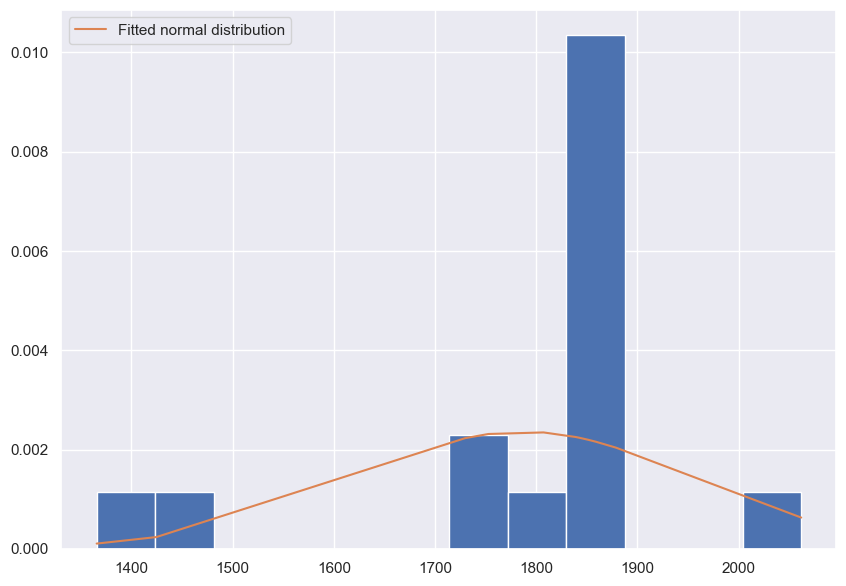

In [68]:
normal_plot(left[left.method == 'baseline'].traj_length)

In [69]:
normal_test_battery(left[left.method == 'baseline'].traj_length)

Shapiro-Wilk s=0.754 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=9.844 p=0.007, data does not look normal (reject H0)

Anderson-Darling s=1.827459940755645
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


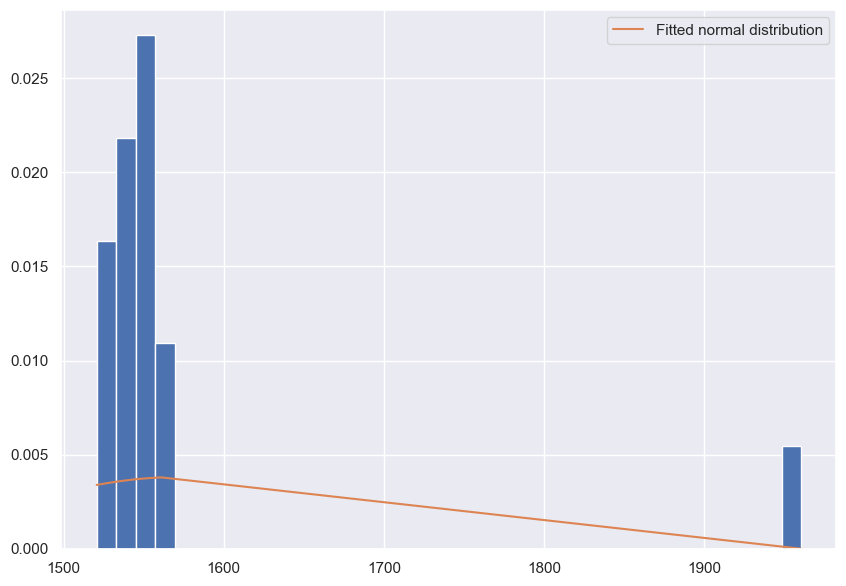

In [70]:
normal_plot(left[left.method == 'mcf'].traj_length)

In [71]:
normal_test_battery(left[left.method == 'mcf'].traj_length)

Shapiro-Wilk s=0.384 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=39.854 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=4.023674783705886
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


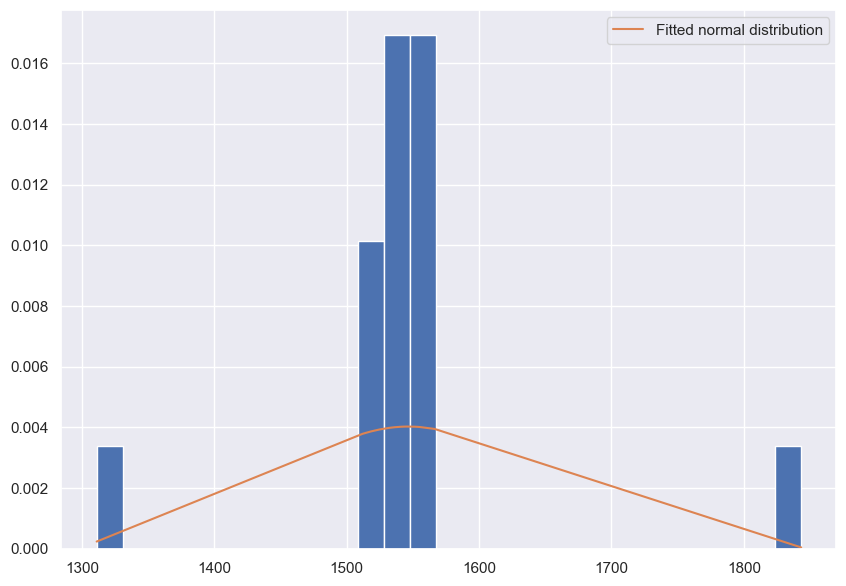

In [72]:
normal_plot(left[left.method == 'mcl'].traj_length)

In [73]:
normal_test_battery(left[left.method == 'mcl'].traj_length)

Shapiro-Wilk s=0.669 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=12.887 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=2.369932191988436
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


In [74]:
print(stats.levene(left[left.method == 'baseline'].traj_length,
                   left[left.method == 'mcf'].traj_length,
                   left[left.method == 'mcl'].traj_length))

LeveneResult(statistic=1.0729201681596778, pvalue=0.35119598767199806)


In [75]:
print(stats.kruskal(left[left.method == 'baseline'].traj_length,
                    left[left.method == 'mcf'].traj_length,
                    left[left.method == 'mcl'].traj_length))

KruskalResult(statistic=12.871884057971016, pvalue=0.001602898014564225)


In [76]:
print(sp.posthoc_dunn(left, val_col='traj_length', group_col='method', p_adjust='bonferroni'))

          baseline       mcf       mcl
baseline  1.000000  0.012025  0.002958
mcf       0.012025  1.000000  1.000000
mcl       0.002958  1.000000  1.000000


## Right

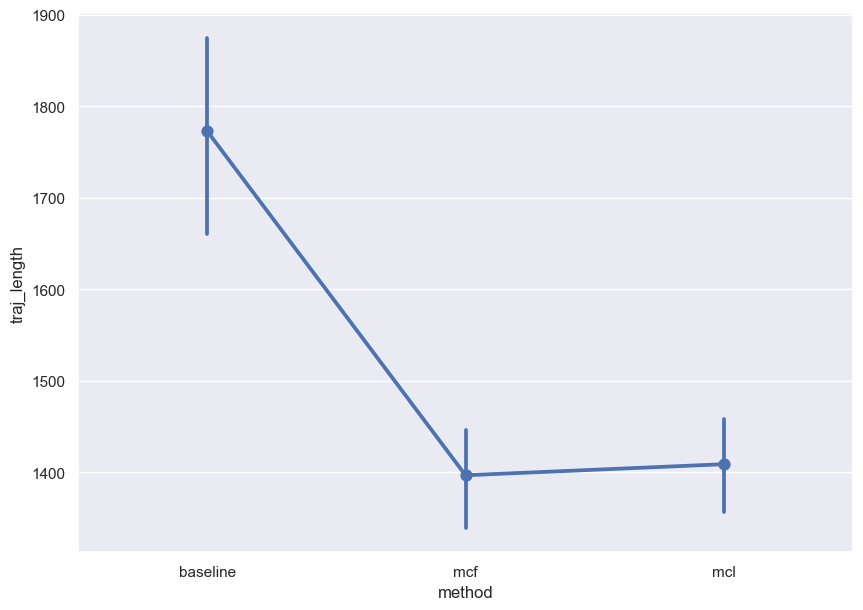

In [77]:
right = df_traj[df_traj.gap == 'right']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=right, x='method', y='traj_length')
plt.show()

In [78]:
print(right.groupby(by='method').traj_length.describe().T)

method     baseline          mcf          mcl
count     15.000000    15.000000    15.000000
mean    1772.817947  1396.890899  1408.985383
std      226.282485   109.665380   104.465183
min     1349.305974  1224.647792  1273.604573
25%     1775.987654  1295.228616  1293.542881
50%     1791.858020  1478.172882  1465.679387
75%     1797.204860  1493.906661  1491.954306
max     2205.090339  1516.397001  1518.206366


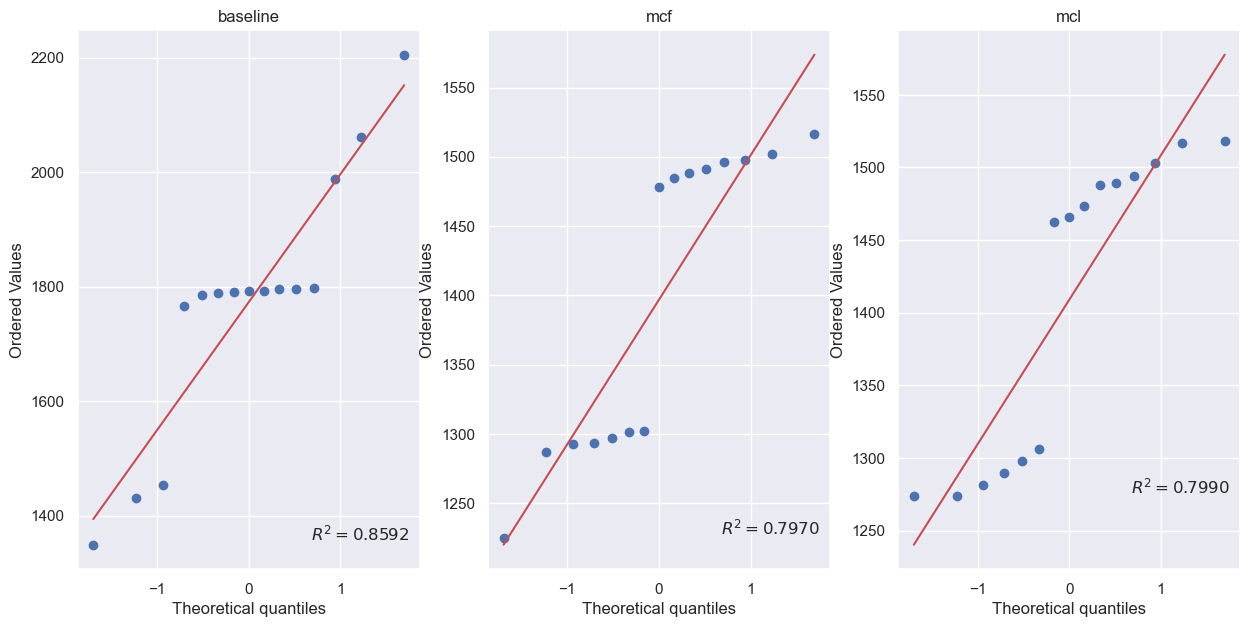

In [79]:
fig, ax = plt.subplots(1, 3, figsize= (15, 7))
stats.probplot(right[right.method == 'baseline'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('baseline', fontsize=12)
stats.probplot(right[right.method == 'mcf'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('mcf', fontsize=12)
stats.probplot(right[right.method == 'mcl'].traj_length, plot=ax[2], rvalue=True)
ax[2].set_title('mcl', fontsize=12)
plt.show()

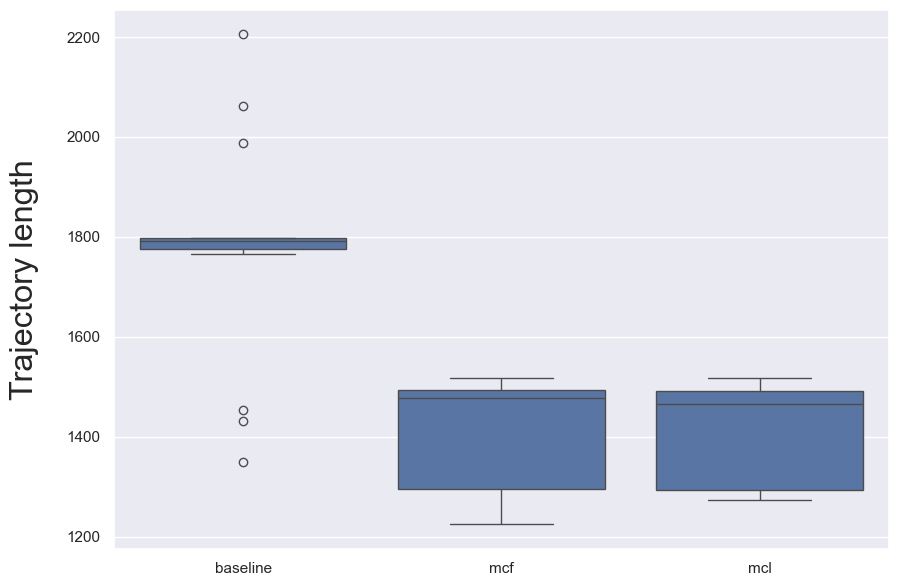

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=right, x='method', y='traj_length')
ax.set_ylabel('Trajectory length', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
plt.savefig('method.png', transparent=False)
plt.show()

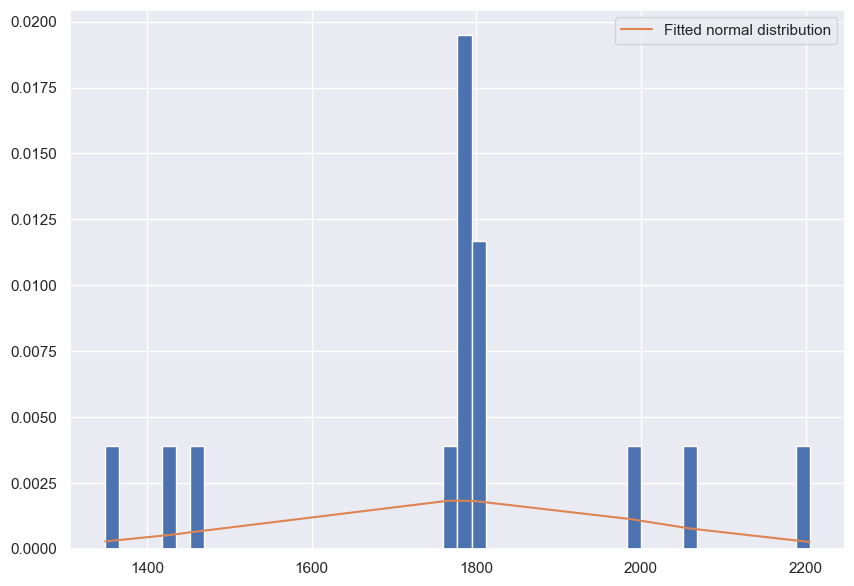

In [81]:
normal_plot(right[right.method == 'baseline'].traj_length)

In [82]:
normal_test_battery(right[right.method == 'baseline'].traj_length)

Shapiro-Wilk s=0.871 p=0.034, data does not look normal (reject H0)
D’Agostino K^2 s=0.553 p=0.758, data looks normal (accept H0)

Anderson-Darling s=1.1381801754242353
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


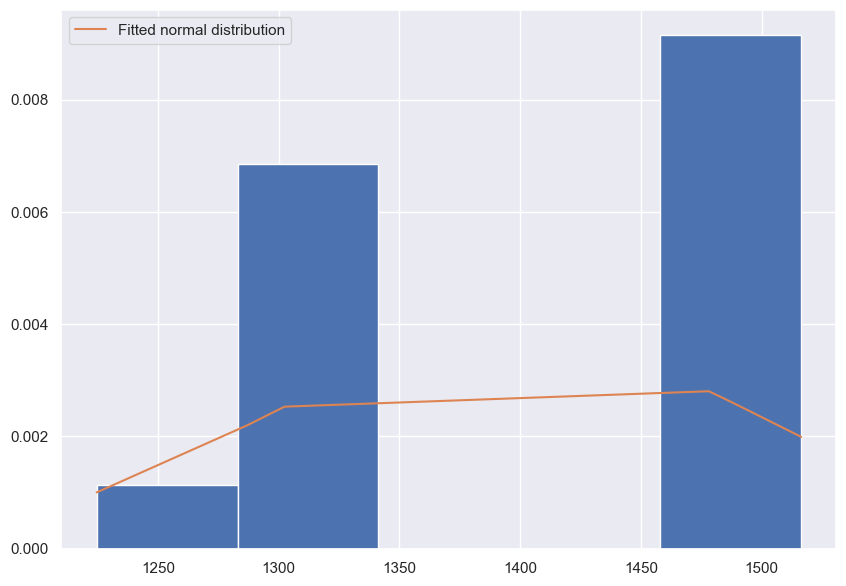

In [83]:
normal_plot(right[right.method == 'mcf'].traj_length)

In [84]:
normal_test_battery(right[right.method == 'mcf'].traj_length)

Shapiro-Wilk s=0.775 p=0.002, data does not look normal (reject H0)
D’Agostino K^2 s=12.783 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=1.6514923692013852
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


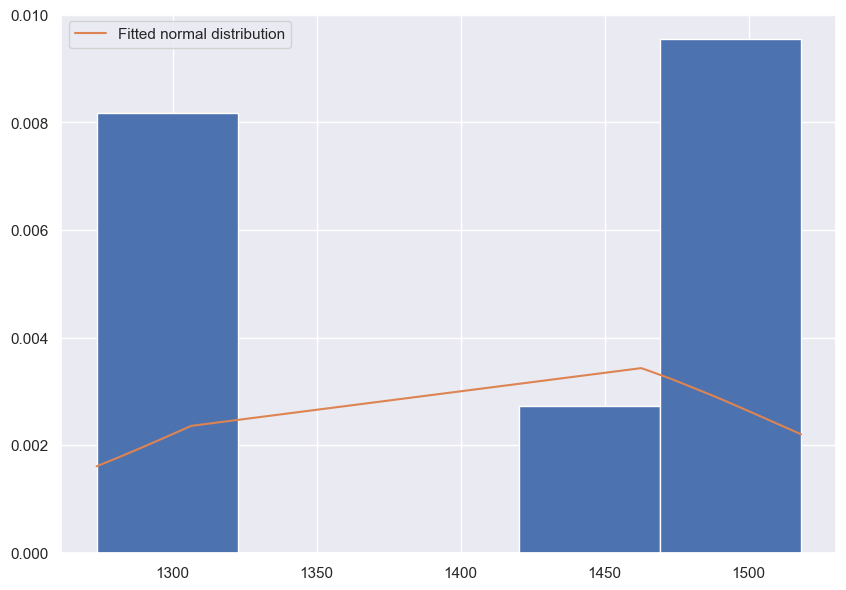

In [85]:
normal_plot(right[right.method == 'mcl'].traj_length)

In [86]:
normal_test_battery(left[left.method == 'mcl'].traj_length)

Shapiro-Wilk s=0.669 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=12.887 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=2.369932191988436
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


In [87]:
print(stats.levene(right[right.method == 'baseline'].traj_length,
                   right[right.method == 'mcf'].traj_length,
                   right[right.method == 'mcl'].traj_length))

LeveneResult(statistic=0.7066102115726918, pvalue=0.49908328961430537)


In [88]:
print(stats.kruskal(right[right.method == 'baseline'].traj_length,
                    right[right.method == 'mcf'].traj_length,
                    right[right.method == 'mcl'].traj_length))

KruskalResult(statistic=17.552077294686, pvalue=0.0001543884625870077)


In [89]:
print(sp.posthoc_dunn(right, val_col='traj_length', group_col='method', p_adjust='bonferroni'))

          baseline       mcf       mcl
baseline  1.000000  0.000811  0.000904
mcf       0.000811  1.000000  1.000000
mcl       0.000904  1.000000  1.000000


# Task completion

In [90]:
print(df.groupby(by=['method']).goal.sum())

method
baseline    13
mcf         30
mcl         30
Name: goal, dtype: int64


In [91]:
print(df.groupby(by=['method', 'gap']).goal.sum())

method    gap  
baseline  left      8
          right     5
mcf       left     15
          right    15
mcl       left     15
          right    15
Name: goal, dtype: int64


# Collisions

In [92]:
print(df.groupby(by='method').collisions.sum())

method
baseline    14
mcf          0
mcl          0
Name: collisions, dtype: int64


In [93]:
print(df.groupby(by=['method', 'gap']).collisions.sum())

method    gap  
baseline  left     9
          right    5
mcf       left     0
          right    0
mcl       left     0
          right    0
Name: collisions, dtype: int64


# Plans

In [94]:
print(df.groupby(by='method').n_plans.describe())

          count      mean       std  min  25%  50%  75%  max
method                                                      
baseline   30.0  4.200000  1.845778  3.0  3.0  3.0  5.0  9.0
mcf        30.0  3.000000  0.525226  2.0  3.0  3.0  3.0  4.0
mcl        30.0  3.266667  0.520830  3.0  3.0  3.0  3.0  5.0


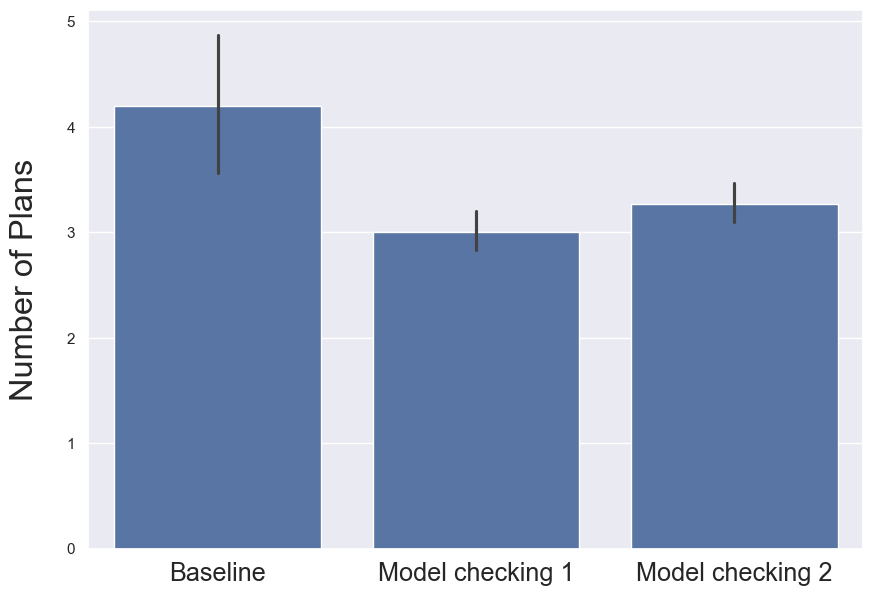

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(data=df, x='method', y='n_plans')
ax.set_ylabel('Number of Plans', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Baseline', 'Model checking 1', 'Model checking 2'], fontsize=14*1.3)
ax.set(xlabel=None)
plt.savefig('methodgoals2.eps', transparent=False)
plt.show()

In [96]:
print(stats.kruskal(df[df.method == 'baseline'].n_plans,
                    df[df.method == 'mcf'].n_plans,
                    df[df.method == 'mcl'].n_plans))

KruskalResult(statistic=12.534137470065296, pvalue=0.0018977833438263685)


In [97]:
print(sp.posthoc_dunn(df, val_col='n_plans', group_col='method', p_adjust='bonferroni'))

          baseline       mcf       mcl
baseline  1.000000  0.001242  0.140586
mcf       0.001242  1.000000  0.368114
mcl       0.140586  0.368114  1.000000


In [98]:
df_plans = df[['run0', 'run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'run8', 'run9']]
df_plans = pd.DataFrame(data=df_plans.T.sum(), columns=['total_latency'])
df_plans['method'] = df.method
print(df_plans)

    total_latency    method
0         554.344  baseline
1         230.604  baseline
2         459.233  baseline
3         583.860  baseline
4         810.233  baseline
..            ...       ...
85        190.469       mcl
86        161.882       mcl
87         96.274       mcl
88        119.241       mcl
89        158.452       mcl

[90 rows x 2 columns]


In [99]:
print(df_plans.groupby(by='method').describe())

         total_latency                                                      \
                 count      mean         std      min        25%       50%   
method                                                                       
baseline          30.0  332.2448  233.149845  173.865  201.77175  230.3425   
mcf               30.0  172.3076   33.096893   96.760  153.62475  167.1390   
mcl               30.0  115.9991   23.773148   89.204   98.73650  107.8590   

                               
                75%       max  
method                         
baseline  308.28875  1114.761  
mcf       187.69300   242.998  
mcl       124.96275   190.469  


method
baseline    [[Axes(0.125,0.11;0.775x0.77)]]
mcf         [[Axes(0.125,0.11;0.775x0.77)]]
mcl         [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

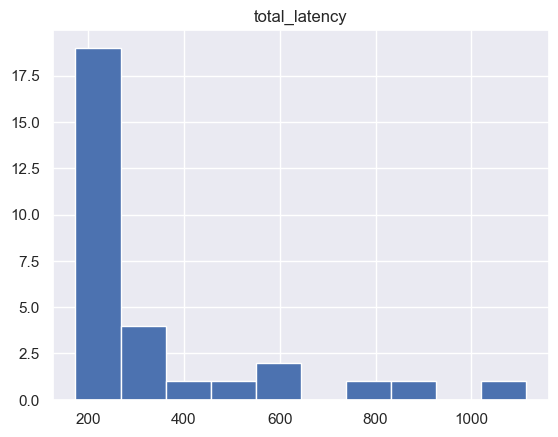

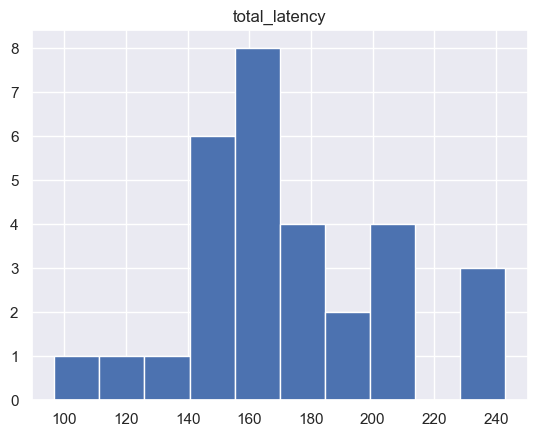

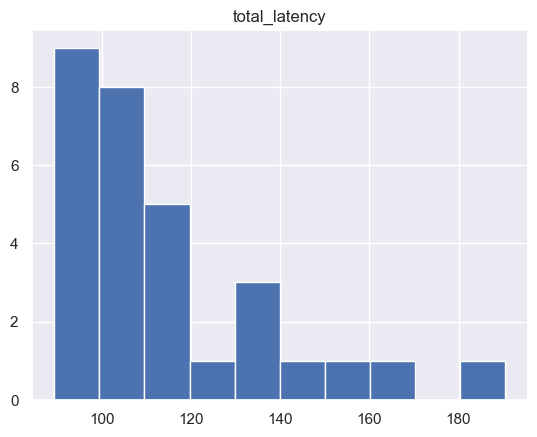

In [100]:
df_plans.groupby(by='method').hist()

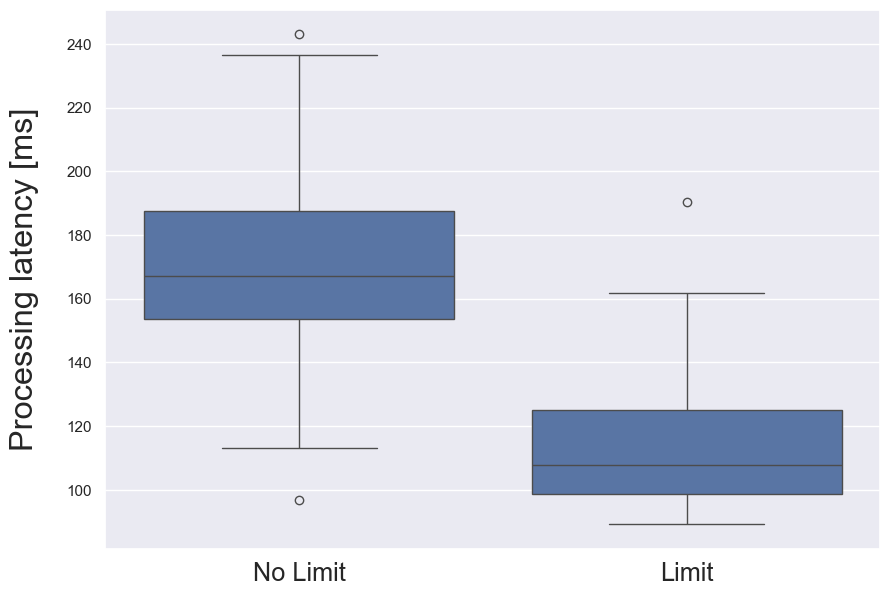

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=df_plans[df_plans.method != 'baseline'], x='method', y='total_latency')
ax.set_ylabel('Processing latency [ms]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['No Limit', 'Limit'], fontsize=14*1.3)
plt.savefig('latency.eps', transparent=False)
plt.show()

In [102]:
df_latency = df[['run0', 'run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'run8', 'run9', 'method']]
print(df_latency.groupby('method').describe())

          run0                                                              \
         count      mean        std     min       25%       50%        75%   
method                                                                       
baseline  30.0  112.6289  20.863116  63.168  105.1945  115.9635  124.52525   
mcf       30.0   92.8829  14.042172  75.636   82.4705   91.5505  104.39850   
mcl       30.0   39.2437   9.589806  33.087   34.0865   36.9310   38.99350   

                   run1             ...      run8          run9               \
              max count       mean  ...       75%     max count mean std min   
method                              ...                                        
baseline  145.010  30.0  51.508967  ...  15.75625  15.817   0.0  NaN NaN NaN   
mcf       120.300  30.0  48.280933  ...       NaN     NaN   0.0  NaN NaN NaN   
mcl        83.669  30.0  40.086033  ...       NaN     NaN   0.0  NaN NaN NaN   

                          
         25% 50% 75% ma

In [103]:
df_plans.total_latency

0     554.344
1     230.604
2     459.233
3     583.860
4     810.233
       ...   
85    190.469
86    161.882
87     96.274
88    119.241
89    158.452
Name: total_latency, Length: 90, dtype: float64

In [104]:
print(stats.kruskal(df_plans[df_plans.method == 'baseline'].total_latency,
                    df_plans[df_plans.method == 'mcf'].total_latency,
                    df_plans[df_plans.method == 'mcl'].total_latency))

KruskalResult(statistic=63.953504273504336, pvalue=1.2962029270212155e-14)


In [105]:
print(sp.posthoc_dunn(df_plans, val_col='total_latency', group_col='method', p_adjust='bonferroni'))

              baseline       mcf           mcl
baseline  1.000000e+00  0.000334  3.868039e-15
mcf       3.341155e-04  1.000000  1.082484e-04
mcl       3.868039e-15  0.000108  1.000000e+00


# Model checking resource usage

In [106]:
mem_usage = (df[df.method == 'mcf'].bfs_max_stack_capacity * df[df.method == 'mcf'].bfs_state_size).max() + \
(df[df.method == 'mcf'].bfs_max_set_size * df[df.method == 'mcf'].bfs_state_size).max() + \
(df[df.method == 'mcf'].bfs_n_states * df[df.method == 'mcf'].bfs_state_size).max() + \
df[df.method == 'mcf'].bfs_adj_list_compile.max() + df[df.method == 'mcf'].bfs_stack_compile.max() + \
df[df.method == 'mcf'].bfs_set_compile.max()

print('Estimated model checking memory usage: {} KB'.format(mem_usage * 8 / 1024))

Estimated model checking memory usage: 2.34375 KB


In [200]:
mem_usage = (df[df.method == 'mcf'].dfs_max_stack_capacity * df[df.method == 'mcf'].dfs_state_size).max() + \
(df[df.method == 'mcf'].dfs_max_set_size * df[df.method == 'mcf'].dfs_state_size).max() + \
(df[df.method == 'mcf'].dfs_n_states * df[df.method == 'mcf'].dfs_state_size).max() + \
df[df.method == 'mcf'].dfs_adj_list_compile.max() + df[df.method == 'mcf'].dfs_stack_compile.max() + \
df[df.method == 'mcf'].dfs_set_compile.max()

print('Estimated model checking memory usage: {} KB'.format(mem_usage * 8 / 1024))

Estimated model checking memory usage: 2.5 KB


In [107]:
df[df.method == 'mcf'].shr_max.max() / 1024

3.12109375

In [261]:
df[df.method == 'mcf'].res_max.max() - df[df.method == 'mcf'].shr_max.max(), df[df.method == 'mcf'].res_max.max() / 1024

(1948, 5.0234375)

In [262]:
1984 / 1024

1.9375

In [109]:
2.34375 / 1948

0.0012031570841889118

In [110]:
2.34375 / (5.0234375 * 1024)

0.0004556279160186625

In [201]:
mem_usage = (df[df.method == 'mcl'].bfs_max_stack_capacity * df[df.method == 'mcl'].bfs_state_size).max() + \
(df[df.method == 'mcl'].bfs_max_set_size * df[df.method == 'mcl'].bfs_state_size).max() + \
(df[df.method == 'mcl'].bfs_n_states * df[df.method == 'mcl'].bfs_state_size).max() + \
df[df.method == 'mcl'].bfs_adj_list_compile.max() + df[df.method == 'mcl'].bfs_stack_compile.max() + \
df[df.method == 'mcl'].bfs_set_compile.max()

print('Estimated model checking memory usage: {} KB'.format(mem_usage * 8 / 1024))

Estimated model checking memory usage: 2.34375 KB


In [202]:
mem_usage = (df[df.method == 'mcl'].dfs_max_stack_capacity * df[df.method == 'mcl'].dfs_state_size).max() + \
(df[df.method == 'mcl'].dfs_max_set_size * df[df.method == 'mcl'].dfs_state_size).max() + \
(df[df.method == 'mcl'].dfs_n_states * df[df.method == 'mcl'].dfs_state_size).max() + \
df[df.method == 'mcl'].dfs_adj_list_compile.max() + df[df.method == 'mcl'].dfs_stack_compile.max() + \
df[df.method == 'mcl'].dfs_set_compile.max()

print('Estimated model checking memory usage: {} KB'.format(mem_usage * 8 / 1024))

Estimated model checking memory usage: 2.5 KB


In [112]:
df[df.method == 'mcl'].shr_max.max() / 1024

3.1171875

In [113]:
df[df.method == 'mcl'].res_max.max() - df[df.method == 'mcl'].shr_max.max(), df[df.method == 'mcl'].res_max.max() / 1024

(1316, 4.40234375)

In [263]:
1316 / 1024

1.28515625

In [114]:
2.5 / 1316

0.001899696048632219

In [115]:
2.5 / (4.40234375 * 1024)

0.0005545696539485359

In [264]:
df[df.method == 'baseline'].shr_max.max() / 1024

3.03125

In [265]:
df[df.method == 'baseline'].res_max.max() - df[df.method == 'baseline'].shr_max.max(), df[df.method == 'baseline'].res_max.max() / 1024

(2772, 5.73828125)

In [266]:
2772 / 1024

2.70703125

In [118]:
df.head()

,gap,pass,method,run,traj_length,collisions,goal,run0,run1,run2,...,swap_total_median,swap_free_min,swap_free_max,swap_free_mean,swap_free_median,swap_used_min,swap_used_max,swap_used_mean,swap_used_median,process_uptime
0,right,right,baseline,0,2205.090339,0,0,134.052,31.391,52.528,...,100,100,100,100,100,0,0,0,0,13.701
1,right,right,baseline,1,1766.261838,0,0,133.866,38.852,57.886,...,100,100,100,100,100,0,0,0,0,11.246
2,right,left,baseline,2,1349.305974,1,1,63.168,38.763,48.509,...,100,100,100,100,100,0,0,0,0,12.107
3,right,left,baseline,3,1453.481414,1,1,120.878,48.769,41.704,...,100,100,100,100,100,0,0,0,0,8.441
4,right,left,baseline,4,1431.427287,1,1,104.271,41.205,36.477,...,100,100,100,100,100,0,0,0,0,10.534


In [119]:
df.tail()

,gap,pass,method,run,traj_length,collisions,goal,run0,run1,run2,...,swap_total_median,swap_free_min,swap_free_max,swap_free_mean,swap_free_median,swap_used_min,swap_used_max,swap_used_mean,swap_used_median,process_uptime
85,left,left,mcl,10,1532.220907,0,1,83.669,36.672,35.214,...,100,100,100,100,100,0,0,0,0,8.876
86,left,left,mcl,11,1843.349227,0,1,36.367,46.282,36.693,...,100,100,100,100,100,0,0,0,0,12.390
87,left,left,mcl,12,1536.126047,0,1,39.017,34.204,23.053,...,100,100,100,100,100,0,0,0,0,9.091
88,left,left,mcl,13,1540.870668,0,1,38.819,38.442,41.980,...,100,100,100,100,100,0,0,0,0,30.677
89,left,left,mcl,14,1551.416792,0,1,33.195,40.825,33.988,...,100,100,100,100,100,0,0,0,0,9.273


In [120]:
len(df)

90

In [168]:
cols = list(df_latency.columns)[:-1]
df_latency['E'] = df_latency[cols].sum(1)
#df_latency[df_latency.method == 'baseline'].iloc[:, :-1].T
# df.assign(E=df_latency[cols].sum(1)).drop(cols, 1)
df_latency

,run0,run1,run2,run3,run4,run5,run6,run7,run8,run9,method,E
0,134.052,31.391,52.528,175.965,160.408,NaN,NaN,NaN,NaN,NaN,baseline,554.344
1,133.866,38.852,57.886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,baseline,230.604
2,63.168,38.763,48.509,279.125,29.668,NaN,NaN,NaN,NaN,NaN,baseline,459.233
3,120.878,48.769,41.704,78.423,276.822,17.264,NaN,NaN,NaN,NaN,baseline,583.860
4,104.271,41.205,36.477,46.637,28.232,263.820,257.739,31.852,NaN,NaN,baseline,810.233
...,...,...,...,...,...,...,...,...,...,...,...,...
85,83.669,36.672,35.214,34.914,NaN,NaN,NaN,NaN,NaN,NaN,mcl,190.469
86,36.367,46.282,36.693,25.228,17.312,NaN,NaN,NaN,NaN,NaN,mcl,161.882
87,39.017,34.204,23.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mcl,96.274
88,38.819,38.442,41.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mcl,119.241


In [190]:
def get_vals(df, cols):
    result = []
    
    for i in range(len(cols)):
        for j in range(len(df)):
            result.append(df.iloc[j, i])
    
    s = pd.DataFrame(result, columns=['V']).dropna()
    return s

cols = list(df_latency.columns)[:-2]
base = df_latency[df_latency.method == 'baseline']
mcf = df_latency[df_latency.method == 'mcf']
mcl = df_latency[df_latency.method == 'mcl']

base_vals = get_vals(base, cols)
mcf_vals = get_vals(mcf, cols)
mcl_vals = get_vals(mcl, cols)

base_vals

,V
0,134.052
1,133.866
2,63.168
3,120.878
4,104.271
...,...
214,31.852
218,32.073
220,261.159
248,15.574


In [229]:
mcf_vals.describe()

,V
count,90.000000
mean,57.435867
std,28.979636
min,20.919000
25%,33.037250
50%,48.692500
75%,81.207750
max,120.300000


In [234]:
mcl_vals.describe()

,mcl
count,98.000000
mean,35.509929
std,9.205559
min,17.312000
25%,32.241250
50%,35.193000
75%,38.897000
max,83.669000


In [244]:
latency = mcl_vals.copy()
latency['method'] = 'mcl'
latency.columns = ['vals', 'method']

latency2 = mcf_vals.copy()
latency2['method'] = 'mcf'
latency2.columns = ['vals', 'method']

latency3 = pd.concat([latency2, latency])
latency3

,vals,method
0,119.480,mcf
1,106.599,mcf
2,120.300,mcf
3,104.520,mcf
4,91.593,mcf
...,...,...
114,24.554,mcl
115,34.914,mcl
116,25.228,mcl
119,50.444,mcl


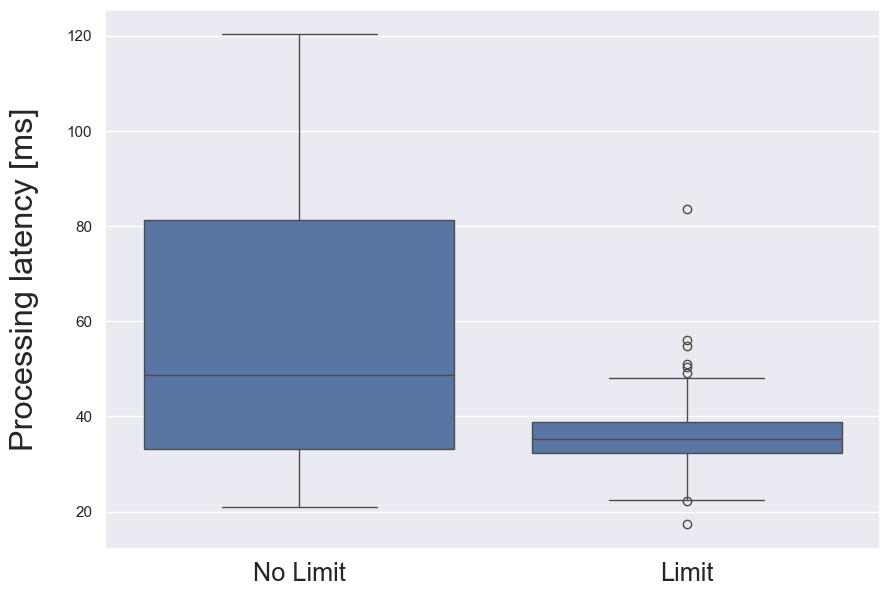

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=latency3, x='method', y='vals')
ax.set_ylabel('Processing latency [ms]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['No Limit', 'Limit'], fontsize=14*1.3)
plt.savefig('latency.eps', transparent=False)
plt.show()

In [249]:
normal_test_battery(mcl_vals.mcl)

Shapiro-Wilk s=0.892 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=46.290 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=1.8801257188485891
15.000: 0.555, data does not look normal (reject H0)
10.000: 0.632, data does not look normal (reject H0)
5.000: 0.758, data does not look normal (reject H0)
2.500: 0.884, data does not look normal (reject H0)
1.000: 1.052, data does not look normal (reject H0)


In [251]:
normal_test_battery(mcf_vals.V)

Shapiro-Wilk s=0.916 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=14.937 p=0.001, data does not look normal (reject H0)

Anderson-Darling s=2.5041800510863936
15.000: 0.553, data does not look normal (reject H0)
10.000: 0.630, data does not look normal (reject H0)
5.000: 0.756, data does not look normal (reject H0)
2.500: 0.882, data does not look normal (reject H0)
1.000: 1.049, data does not look normal (reject H0)


In [254]:
print(stats.mannwhitneyu(mcl_vals.mcl, 
                         mcf_vals.V, alternative='less'))

MannwhitneyuResult(statistic=2533.0, pvalue=2.392930955729439e-07)


In [256]:
latency3['rank'] = latency3.vals.rank(method='min').values
mcl_ranked = latency3[latency3.method == 'mcl']
mcf_ranked = latency3[latency3.method == 'mcf']

mannwhitney_stats(mcl_ranked['rank'], mcf_ranked['rank'])

Sum of ranks sample 1: 7384.0
Mean rank sample 1: 75.34693877551021
U sample 1: 6287.0

Sum of ranks sample 2: 10382.0
Mean rank sample 2: 115.35555555555555
U sample 2: 2533.0

Test stat U: 2533.0
Expected value of U: 4410.0
Standard error of U: 912.9567350099346
z-value: -2.055957229977141
Effect size r=0.2076830427351924


ConfidenceInterval(low=69.1565704118031, high=91.80689717656324)


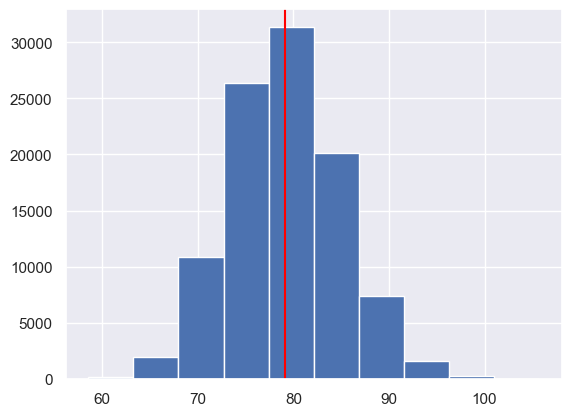

In [196]:
result = stats.bootstrap((base_vals.V, ), 
                          statistic=np.mean, 
                          n_resamples=100000,
                          confidence_level=0.95)

reference = base_vals.V.mean()
plt.hist(result.bootstrap_distribution, bins=10)
plt.axvline(reference, color='red')
print(result.confidence_interval)

ConfidenceInterval(low=51.7692279568053, high=63.68863011998926)


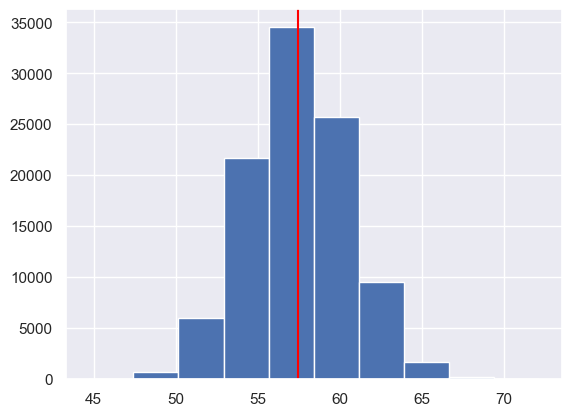

In [198]:
result = stats.bootstrap((mcf_vals.V, ), 
                          statistic=np.mean, 
                          n_resamples=100000,
                          confidence_level=0.95)

reference = mcf_vals.V.mean()
plt.hist(result.bootstrap_distribution, bins=10)
plt.axvline(reference, color='red')
print(result.confidence_interval)

ConfidenceInterval(low=33.87454442659256, high=37.55941408126932)


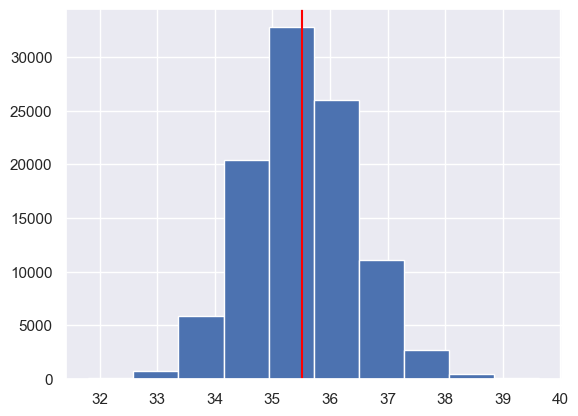

In [199]:
result = stats.bootstrap((mcl_vals.V, ), 
                          statistic=np.mean, 
                          n_resamples=100000,
                          confidence_level=0.95)

reference = mcl_vals.V.mean()
plt.hist(result.bootstrap_distribution, bins=10)
plt.axvline(reference, color='red')
print(result.confidence_interval)

In [267]:
13 /30

0.43333333333333335